<a href="https://colab.research.google.com/github/Giraldo0712/TAM_2025_2/blob/main/Parcial_1_TAM/Punto__4_ParcialTAM_NFL_Big_Data_Bowl_2026_Analysis_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nfl_big_data_bowl_2026_prediction_path = kagglehub.competition_download('nfl-big-data-bowl-2026-prediction')

print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# (Opcional) instalar RAPIDS si hay GPU
!pip -q install cudf-cu12 cuml-cu12 --extra-index-url=https://pypi.nvidia.com

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os # Import the os module
warnings.filterwarnings('ignore')

# ============================================================================
# GPU CONFIGURATION & OPTIMIZATION
# ============================================================================

def setup_gpu():
    """Configure GPU for optimal performance"""
    print("="*80)
    print("GPU CONFIGURATION")
    print("="*80)

    # Check available GPUs
    gpus = tf.config.list_physical_devices('GPU')
    print(f"\n🖥️  Available GPUs: {len(gpus)}")

    if gpus:
        try:
            # Enable memory growth (don't allocate all GPU memory at once)
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                print(f"   ✓ GPU: {gpu.name} - Memory growth enabled")

            # Set GPU memory limit (optional - useful if sharing GPU)
            # tf.config.set_logical_device_configuration(
            #     gpus[0],
            #     [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # 4GB
            # )

            # Use mixed precision for faster training
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print(f"   ✓ Mixed precision enabled: {policy.name}")

            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"   ✓ Logical GPUs: {len(logical_gpus)}")

        except RuntimeError as e:
            print(f"   ⚠️  GPU configuration error: {e}")
    else:
        print("   ⚠️  No GPU found - using CPU (training will be slower)")

    # Set TensorFlow options for better performance
    tf.config.optimizer.set_jit(True)  # XLA compilation
    print("   ✓ XLA (Accelerated Linear Algebra) enabled")

    print(f"\n📊 TensorFlow version: {tf.__version__}")
    print(f"📊 Keras version: {keras.__version__}")

    return len(gpus) > 0

# ============================================================================
# CONFIGURATION
# ============================================================================

CONFIG = {
    'sequence_length': 10,
    'max_frames_to_predict': 15,
    'batch_size': 256,  # Larger batch for GPU
    'epochs': 100,
    'learning_rate': 0.001,
    'validation_split': 0.15,
    'use_gpu': True,
}

# ============================================================================
# EVALUATION METRICS
# ============================================================================

def calculate_rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error"""
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def calculate_mae(y_true, y_pred):
    """Calculate Mean Absolute Error"""
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def calculate_euclidean_distance(y_true, y_pred):
    """Calculate Euclidean distance between predicted and actual positions"""
    distances = np.sqrt((y_true[:, 0] - y_pred[:, 0])**2 +
                       (y_true[:, 1] - y_pred[:, 1])**2)
    return distances

def evaluate_predictions(y_true, y_pred, split_name="Validation"):
    """Comprehensive evaluation of predictions"""
    print("\n" + "="*80)
    print(f"📊 {split_name.upper()} SET EVALUATION")
    print("="*80)

    # Overall metrics
    x_rmse = calculate_rmse(y_true[:, 0], y_pred[:, 0])
    y_rmse = calculate_rmse(y_true[:, 1], y_pred[:, 1])

    x_mae = calculate_mae(y_true[:, 0], y_pred[:, 0])
    y_mae = calculate_mae(y_true[:, 1], y_pred[:, 1])

    # Euclidean distance
    distances = calculate_euclidean_distance(y_true, y_pred)
    mean_distance = np.mean(distances)
    median_distance = np.median(distances)

    print(f"\n🎯 POSITION ACCURACY:")
    print(f"   X-coordinate:")
    print(f"      RMSE: {x_rmse:.3f} yards")
    print(f"      MAE:  {x_mae:.3f} yards")

    print(f"\n   Y-coordinate:")
    print(f"      RMSE: {y_rmse:.3f} yards")
    print(f"      MAE:  {y_mae:.3f} yards")

    print(f"\n📏 EUCLIDEAN DISTANCE:")
    print(f"   Mean:   {mean_distance:.3f} yards")
    print(f"   Median: {median_distance:.3f} yards")
    print(f"   Std:    {np.std(distances):.3f} yards")
    print(f"   Min:    {np.min(distances):.3f} yards")
    print(f"   Max:    {np.max(distances):.3f} yards")

    # Percentiles
    print(f"\n📊 DISTANCE PERCENTILES:")
    for p in [25, 50, 75, 90, 95, 99]:
        print(f"   {p}th percentile: {np.percentile(distances, p):.3f} yards")

    # Accuracy buckets
    print(f"\n🎯 ACCURACY BUCKETS:")
    for threshold in [1, 2, 5, 10, 15, 20]:
        within = (distances <= threshold).sum()
        pct = 100 * within / len(distances)
        print(f"   Within {threshold:2d} yards: {within:6,} ({pct:5.2f}%)")

    metrics = {
        'x_rmse': x_rmse,
        'y_rmse': y_rmse,
        'x_mae': x_mae,
        'y_mae': y_mae,
        'mean_distance': mean_distance,
        'median_distance': median_distance,
        'distances': distances
    }

    return metrics

def plot_predictions(y_true, y_pred, split_name="Validation", save_path="predictions_plot.png"):
    """Visualize predictions vs actual"""

    fig = plt.figure(figsize=(20, 12))

    # 1. X predictions scatter
    ax1 = plt.subplot(2, 3, 1)
    ax1.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.3, s=1)
    ax1.plot([0, 120], [0, 120], 'r--', linewidth=2)
    ax1.set_xlabel('Actual X (yards)', fontsize=12)
    ax1.set_ylabel('Predicted X (yards)', fontsize=12)
    ax1.set_title(f'{split_name} - X Coordinate', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)

    # 2. Y predictions scatter
    ax2 = plt.subplot(2, 3, 2)
    ax2.scatter(y_true[:, 1], y_pred[:, 1], alpha=0.3, s=1)
    ax2.plot([0, 53.3], [0, 53.3], 'r--', linewidth=2)
    ax2.set_xlabel('Actual Y (yards)', fontsize=12)
    ax2.set_ylabel('Predicted Y (yards)', fontsize=12)
    ax2.set_title(f'{split_name} - Y Coordinate', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)

    # 3. Error distribution
    ax3 = plt.subplot(2, 3, 3)
    distances = calculate_euclidean_distance(y_true, y_pred)
    ax3.hist(distances, bins=50, alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(distances), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(distances):.2f}')
    ax3.set_xlabel('Euclidean Distance Error (yards)', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.set_title('Prediction Error Distribution', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)

    # 4. X error distribution
    ax4 = plt.subplot(2, 3, 4)
    x_errors = y_true[:, 0] - y_pred[:, 0]
    ax4.hist(x_errors, bins=50, alpha=0.7, edgecolor='black', color='green')
    ax4.axvline(0, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('X Error (yards)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title(f'X Error - Mean: {np.mean(x_errors):.3f}', fontsize=14, fontweight='bold')
    ax4.grid(alpha=0.3)

    # 5. Y error distribution
    ax5 = plt.subplot(2, 3, 5)
    y_errors = y_true[:, 1] - y_pred[:, 1]
    ax5.hist(y_errors, bins=50, alpha=0.7, edgecolor='black', color='orange')
    ax5.axvline(0, color='red', linestyle='--', linewidth=2)
    ax5.set_xlabel('Y Error (yards)', fontsize=12)
    ax5.set_ylabel('Frequency', fontsize=12)
    ax5.set_title(f'Y Error - Mean: {np.mean(y_errors):.3f}', fontsize=14, fontweight='bold')
    ax5.grid(alpha=0.3)

    # 6. Cumulative accuracy
    ax6 = plt.subplot(2, 3, 6)
    sorted_distances = np.sort(distances)
    cumulative = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances) * 100
    ax6.plot(sorted_distances, cumulative, linewidth=2)
    ax6.set_xlabel('Distance Threshold (yards)', fontsize=12)
    ax6.set_ylabel('Cumulative % of Predictions', fontsize=12)
    ax6.set_title('Cumulative Accuracy Curve', fontsize=14, fontweight='bold')
    ax6.grid(alpha=0.3)

    # Add benchmarks
    for threshold in [5, 10, 15]:
        pct = (distances <= threshold).sum() / len(distances) * 100
        ax6.axvline(threshold, linestyle='--', alpha=0.5)
        ax6.text(threshold, pct, f'{pct:.1f}%', fontsize=10)

    plt.suptitle(f'{split_name} Set - Prediction Analysis',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved plot: {save_path}")

    return fig

def plot_training_history(history, save_path="training_history.png"):
    """Plot training history"""

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # MAE plot
    axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE (yards)', fontsize=12)
    axes[1].set_title('Training and Validation MAE', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved plot: {save_path}")

    return fig

# ============================================================================
# IMPORT FUNCTIONS FROM ORIGINAL CODE
# ============================================================================

def parse_height(height_str):
    if pd.isna(height_str):
        return np.nan
    try:
        feet, inches = map(int, str(height_str).split('-'))
        return feet * 12 + inches
    except:
        return np.nan

def calculate_age(birth_date, reference_date='2023-09-01'):
    try:
        birth = pd.to_datetime(birth_date)
        ref = pd.to_datetime(reference_date)
        return (ref - birth).days / 365.25
    except:
        return np.nan

def load_training_data(data_path='.'): # Changed default data_path to '.'
    print("\n" + "="*80)
    print("LOADING TRAINING DATA")
    print("="*80)

    all_data = []
    # Adjusted file path based on kagglehub download behavior
    for week in range(1, 19):
        file_path = os.path.join(data_path, 'train', f'input_2023_w{week:02d}.csv') # Adjusted path
        try:
            df = pd.read_csv(file_path)
            all_data.append(df)
            print(f"✓ Week {week:02d}: {len(df):,} rows | {df['play_id'].nunique():,} plays")
        except FileNotFoundError:
            print(f"✗ Week {week:02d}: File not found at {file_path}") # Added file_path to message

    if not all_data:
        raise ValueError("No training data files found.") # Added check for empty all_data

    train_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal training data: {len(train_df):,} rows")
    print(f" Unique plays: {(train_df['game_id'].astype(str) + '_' + train_df['play_id'].astype(str)).nunique():,}")
    print(f"Players to predict: {train_df['player_to_predict'].sum():,}")

    return train_df

def load_test_data(data_path='.'):
    print("\n" + "="*80)
    print("LOADING TEST DATA")
    print("="*80)

    # Adjusted file paths based on kagglehub download behavior
    test_input = pd.read_csv(os.path.join(data_path, 'test_input.csv'))
    test_targets = pd.read_csv(os.path.join(data_path, 'test.csv'))

    print(f"✓ Test input: {len(test_input):,} rows")
    print(f"✓ Test targets: {len(test_targets):,} predictions needed")

    return test_input, test_targets

def normalize_play_direction(df):
    df = df.copy()
    left_mask = df['play_direction'] == 'left'
    num_flipped = left_mask.sum()

    df.loc[left_mask, 'x'] = 120 - df.loc[left_mask, 'x']
    df.loc[left_mask, 'y'] = 53.3 - df.loc[left_mask, 'y']
    df.loc[left_mask, 'dir'] = (df.loc[left_mask, 'dir'] + 180) % 360
    df.loc[left_mask, 'o'] = (df.loc[left_mask, 'o'] + 180) % 360

    if 'ball_land_x' in df.columns:
        df.loc[left_mask, 'ball_land_x'] = 120 - df.loc[left_mask, 'ball_land_x']
        df.loc[left_mask, 'ball_land_y'] = 53.3 - df.loc[left_mask, 'ball_land_y']

    print(f"   Normalized {num_flipped:,} plays moving left → right")
    return df

def engineer_features(df):
    print("\n" + "="*80)
    print("FEATURE ENGINEERING")
    print("="*80)

    df = df.copy()

    print("✓ Computing velocity components (vx, vy)")
    df['vx'] = df['s'] * np.cos(np.radians(df['dir']))
    df['vy'] = df['s'] * np.sin(np.radians(df['dir']))

    print("✓ Computing orientation components (ox, oy)")
    df['ox'] = np.cos(np.radians(df['o']))
    df['oy'] = np.sin(np.radians(df['o']))

    if 'ball_land_x' in df.columns:
        print("✓ Computing ball landing features")
        df['dist_to_ball'] = np.sqrt(
            (df['x'] - df['ball_land_x'])**2 +
            (df['y'] - df['ball_land_y'])**2
        )
        df['angle_to_ball'] = np.arctan2(
            df['ball_land_y'] - df['y'],
            df['ball_land_x'] - df['x']
        )
        df['vel_toward_ball'] = df['s'] * np.cos(np.radians(df['dir']) - df['angle_to_ball'])
    else:
        df['dist_to_ball'] = 0
        df['angle_to_ball'] = 0
        df['vel_toward_ball'] = 0

    print("✓ Computing field position features")
    df['dist_to_left_sideline'] = df['y']
    df['dist_to_right_sideline'] = 53.3 - df['y']
    df['dist_to_nearest_sideline'] = np.minimum(df['y'], 53.3 - df['y'])
    df['dist_to_endzone'] = 120 - df['x']

    print("✓ Processing player attributes")
    df['height_inches'] = df['player_height'].apply(parse_height)
    df['height_inches'] = df['height_inches'].fillna(df['height_inches'].median())

    df['player_age'] = df['player_birth_date'].apply(calculate_age)
    df['player_age'] = df['player_age'].fillna(df['player_age'].median())

    df['bmi'] = (df['player_weight'] * 703) / (df['height_inches'] ** 2)
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())

    print("✓ Creating temporal features (lags, differences)")
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])

    group_cols = ['game_id', 'play_id', 'nfl_id']
    for lag in [1, 2, 3]:
        for col in ['x', 'y', 's', 'a', 'vx', 'vy']:
            df[f'{col}_lag{lag}'] = df.groupby(group_cols)[col].shift(lag)

    df['speed_change'] = df.groupby(group_cols)['s'].diff()
    df['accel_change'] = df.groupby(group_cols)['a'].diff()
    df['dir_change'] = df.groupby(group_cols)['dir'].diff()

    df.loc[df['dir_change'] > 180, 'dir_change'] -= 360
    df.loc[df['dir_change'] < -180, 'dir_change'] += 360

    print("✓ Computing rolling statistics")
    for col in ['s', 'a']:
        df[f'{col}_roll_mean'] = df.groupby(group_cols)[col].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
        )
        df[f'{col}_roll_std'] = df.groupby(group_cols)[col].transform(
            lambda x: x.rolling(window=3, min_periods=1).std()
        )

    df = df.fillna(method='bfill').fillna(method='ffill').fillna(0)

    print(f"\n📊 Features created: {len(df.columns)} total columns")

    return df

def encode_categorical(df, encoders=None):
    df = df.copy()
    categorical_cols = ['player_position', 'player_side', 'player_role']

    if encoders is None:
        encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
        return df, encoders
    else:
        for col in categorical_cols:
            if col in encoders:
                df[col] = df[col].astype(str).map(
                    lambda x: x if x in encoders[col].classes_ else encoders[col].classes_[0]
                )
                df[col] = encoders[col].transform(df[col])
        return df

def create_sequences(df, sequence_length=10, for_training=True):
    print("\n" + "="*80)
    print("CREATING SEQUENCES")
    print("="*80)

    sequence_features = [
        'x', 'y', 's', 'a', 'vx', 'vy', 'ox', 'oy', 'dir', 'o',
        'x_lag1', 'y_lag1', 's_lag1', 'a_lag1',
        'x_lag2', 'y_lag2', 's_lag2', 'a_lag2',
        'x_lag3', 'y_lag3', 's_lag3', 'a_lag3',
        'speed_change', 'accel_change', 'dir_change',
        's_roll_mean', 'a_roll_mean',
        'dist_to_left_sideline', 'dist_to_right_sideline', 'dist_to_nearest_sideline'
    ]

    static_features = [
        'player_position', 'player_side', 'player_role',
        'height_inches', 'player_weight', 'player_age', 'bmi',
        'absolute_yardline_number', 'dist_to_ball', 'angle_to_ball'
    ]

    sequences = []
    static_data = []
    targets = []
    metadata = []

    grouped = df.groupby(['game_id', 'play_id', 'nfl_id'])

    for (game_id, play_id, nfl_id), group in grouped:
        if for_training and not group['player_to_predict'].any():
            continue

        group = group.sort_values('frame_id')

        if len(group) < sequence_length:
            continue

        seq_data = group[sequence_features].iloc[-sequence_length:].values
        static = group[static_features].iloc[-1].values

        sequences.append(seq_data)
        static_data.append(static)

        if for_training and 'ball_land_x' in group.columns:
            target_x = group['ball_land_x'].iloc[-1]
            target_y = group['ball_land_y'].iloc[-1]
            targets.append([target_x, target_y])

        metadata.append({
            'game_id': game_id,
            'play_id': play_id,
            'nfl_id': nfl_id,
            'num_frames_output': group['num_frames_output'].iloc[-1] if 'num_frames_output' in group.columns else 0,
            'last_x': group['x'].iloc[-1],
            'last_y': group['y'].iloc[-1],
        })

    sequences = np.array(sequences, dtype=np.float32)
    static_data = np.array(static_data, dtype=np.float32)

    if for_training and len(targets) > 0:
        targets = np.array(targets, dtype=np.float32)
    else:
        targets = None

    print(f"✓ Created {len(sequences):,} sequences")
    print(f"✓ Sequence shape: {sequences.shape}")
    print(f"✓ Static shape: {static_data.shape}")
    if targets is not None:
        print(f"✓ Target shape: {targets.shape}")

    return sequences, static_data, targets, metadata

def build_model(sequence_shape, static_shape):
    print("\n" + "="*80)
    print("BUILDING MODEL")
    print("="*80)

    sequence_input = layers.Input(shape=sequence_shape, name='sequence_input')

    x = layers.LSTM(128, return_sequences=True)(sequence_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    static_input = layers.Input(shape=(static_shape,), name='static_input')
    s = layers.Dense(64, activation='relu')(static_input)
    s = layers.BatchNormalization()(s)
    s = layers.Dropout(0.2)(s)
    s = layers.Dense(32, activation='relu')(s)

    combined = layers.concatenate([x, s])

    z = layers.Dense(128, activation='relu')(combined)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.3)(z)

    z = layers.Dense(64, activation='relu')(z)
    z = layers.Dropout(0.2)(z)

    # For mixed precision, use float32 output
    output = layers.Dense(2, dtype='float32', name='position_output')(z)

    model = keras.Model(
        inputs=[sequence_input, static_input],
        outputs=output
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae', 'mse']
    )

    model.summary()

    return model

def train_model(model, X_seq, X_static, y, validation_split=0.15):
    print("\n" + "="*80)
    print("TRAINING MODEL")
    print("="*80)

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    history = model.fit(
        [X_seq, X_static], y,
        batch_size=CONFIG['batch_size'],
        epochs=CONFIG['epochs'],
        validation_split=validation_split,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def create_submission(model, test_input, test_targets, metadata_lookup, scalers):
    print("\n" + "="*80)
    print("GENERATING PREDICTIONS")
    print("="*80)

    pred_dict = {}
    for meta, pred in zip(metadata_lookup, model.predict([test_input[0], test_input[1]], verbose=1)):
        key = (meta['game_id'], meta['play_id'], meta['nfl_id'])
        pred_dict[key] = {
            'x': pred[0],
            'y': pred[1],
            'last_x': meta['last_x'],
            'last_y': meta['last_y']
        }

    submissions = []
    for _, row in test_targets.iterrows():
        key = (row['game_id'], row['play_id'], row['nfl_id'])

        if key in pred_dict:
            x_pred = pred_dict[key]['x']
            y_pred = pred_dict[key]['y']
        else:
            x_pred = 60.0
            y_pred = 26.65

        submissions.append({
            'id': f"{row['game_id']}_{row['play_id']}_{row['nfl_id']}_{row['frame_id']}",
            'x': x_pred,
            'y': y_pred
        })

    submission_df = pd.DataFrame(submissions)
    submission_df.to_csv('submission.csv', index=False)

    print(f"✓ Submission created: {len(submission_df):,} predictions")
    print(f"✓ Saved to: submission.csv")

    return submission_df

# ============================================================================
# MAIN PIPELINE WITH EVALUATION
# ============================================================================
'''
def main():
    start_time = datetime.now()

    print("\n" + "="*80)
    print(" NFL BIG DATA BOWL 2026 - ENHANCED PIPELINE WITH EVALUATION")
    print("="*80)

    # Setup GPU
    has_gpu = setup_gpu()

    # Load data
    train_df = load_training_data()
    test_input_df, test_targets_df = load_test_data()

    # Preprocess
    print("\n📍 Step 1: Normalizing play direction...")
    train_df = normalize_play_direction(train_df)
    test_input_df = normalize_play_direction(test_input_df)

    # Feature engineering
    print("\n📍 Step 2: Feature engineering...")
    train_df = engineer_features(train_df)
    test_input_df = engineer_features(test_input_df)

    # Encode categorical
    print("\n📍 Step 3: Encoding categorical variables...")
    train_df, encoders = encode_categorical(train_df)
    test_input_df = encode_categorical(test_input_df, encoders)

    # Create sequences
    print("\n📍 Step 4: Creating sequences...")
    X_seq_all, X_static_all, y_all, metadata_all = create_sequences(
        train_df, CONFIG['sequence_length'], for_training=True
    )

    X_seq_test, X_static_test, _, metadata_test = create_sequences(
        test_input_df, CONFIG['sequence_length'], for_training=False
    )

    # Split train/validation
    print("\n📍 Step 5: Splitting train/validation...")
    n_samples = len(X_seq_all)
    n_val = int(n_samples * CONFIG['validation_split'])

    # Random shuffle
    indices = np.random.permutation(n_samples)
    train_idx = indices[n_val:]
    val_idx = indices[:n_val]

    X_seq_train = X_seq_all[train_idx]
    X_static_train = X_static_all[train_idx]
    y_train = y_all[train_idx]

    X_seq_val = X_seq_all[val_idx]
    X_static_val = X_static_all[val_idx]
    y_val = y_all[val_idx]

    print(f"   Training samples: {len(X_seq_train):,}")
    print(f"   Validation samples: {len(X_seq_val):,}")

    # Scale features
    print("\n📍 Step 6: Scaling features...")
    scaler_seq = StandardScaler()
    scaler_static = StandardScaler()

    # Scale sequence features
    X_seq_train_flat = X_seq_train.reshape(-1, X_seq_train.shape[-1])
    X_seq_train_scaled = scaler_seq.fit_transform(X_seq_train_flat).reshape(X_seq_train.shape)

    X_seq_val_flat = X_seq_val.reshape(-1, X_seq_val.shape[-1])
    X_seq_val_scaled = scaler_seq.transform(X_seq_val_flat).reshape(X_seq_val.shape)

    # Scale static features
    X_static_train_scaled = scaler_static.fit_transform(X_static_train)
    X_static_val_scaled = scaler_static.transform(X_static_val)

    # Scale test features
    X_seq_test_flat = X_seq_test.reshape(-1, X_seq_test.shape[-1])
    X_seq_test_scaled = scaler_seq.transform(X_seq_test_flat).reshape(X_seq_test.shape)
    X_static_test_scaled = scaler_static.transform(X_static_test)

    # Build model
    print("\n📍 Step 7: Building model...")
    model = build_model(
        sequence_shape=(X_seq_train.shape[1], X_seq_train.shape[2]),
        static_shape=X_static_train.shape[1]
    )

    # Train model WITHOUT validation_split (we already split)
    print("\n📍 Step 8: Training model...")

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    history = model.fit(
        [X_seq_train_scaled, X_static_train_scaled], y_train,
        validation_data=([X_seq_val_scaled, X_static_val_scaled], y_val),
        batch_size=CONFIG['batch_size'],
        epochs=CONFIG['epochs'],
        callbacks=callbacks,
        verbose=1
    )

    # Plot training history
    print("\n📍 Step 9: Plotting training history...")
    plot_training_history(history, "training_history.png")

    # Evaluate on training set
    print("\n📍 Step 10: Evaluating on training set...")
    y_train_pred = model.predict([X_seq_train_scaled, X_static_train_scaled], verbose=0)
    train_metrics = evaluate_predictions(y_train, y_train_pred, "Training")
    plot_predictions(y_train, y_train_pred, "Training", "predictions_train.png")

    # Evaluate on validation set
    print("\n📍 Step 11: Evaluating on validation set...")
    y_val_pred = model.predict([X_seq_val_scaled, X_static_val_scaled], verbose=0)
    val_metrics = evaluate_predictions(y_val, y_val_pred, "Validation")
    plot_predictions(y_val, y_val_pred, "Validation", "predictions_val.png")

    # Save model and artifacts
    print("\n📍 Step 12: Saving model and artifacts...")
    model.save('nfl_model_final.keras')
    with open('scalers.pkl', 'wb') as f:
        pickle.dump({'seq': scaler_seq, 'static': scaler_static, 'encoders': encoders}, f)

    # Save metrics to file
    metrics_summary = {
        'training': {
            'x_rmse': float(train_metrics['x_rmse']),
            'y_rmse': float(train_metrics['y_rmse']),
            'x_mae': float(train_metrics['x_mae']),
            'y_mae': float(train_metrics['y_mae']),
            'mean_distance': float(train_metrics['mean_distance']),
            'median_distance': float(train_metrics['median_distance'])
        },
        'validation': {
            'x_rmse': float(val_metrics['x_rmse']),
            'y_rmse': float(val_metrics['y_rmse']),
            'x_mae': float(val_metrics['x_mae']),
            'y_mae': float(val_metrics['y_mae']),
            'mean_distance': float(val_metrics['mean_distance']),
            'median_distance': float(val_metrics['median_distance'])
        }
    }

    with open('metrics.pkl', 'wb') as f:
        pickle.dump(metrics_summary, f)

    # Create submission
    print("\n📍 Step 13: Creating submission...")
    submission = create_submission(
        model,
        (X_seq_test_scaled, X_static_test_scaled),
        test_targets_df,
        metadata_test,
        {'seq': scaler_seq, 'static': scaler_static}
    )

    # Final summary
    end_time = datetime.now()
    duration = end_time - start_time

    print("\n" + "="*80)
    print("✅ PIPELINE COMPLETE!")
    print("="*80)

    print(f"\n⏱️  Total Time: {duration}")

    print(f"\n📁 Files created:")
    print(f"   • nfl_model_final.keras - Trained model")
    print(f"   • best_model.keras - Best model checkpoint")
    print(f"   • scalers.pkl - Feature scalers and encoders")
    print(f"   • metrics.pkl - Evaluation metrics")
    print(f"   • submission.csv - Final predictions ({len(submission):,} rows)")
    print(f"   • training_history.png - Training curves")
    print(f"   • predictions_train.png - Training set predictions")
    print(f"   • predictions_val.png - Validation set predictions")

    print(f"\n📊 FINAL RESULTS:")
    print(f"\n   Training Set:")
    print(f"      RMSE (X): {train_metrics['x_rmse']:.3f} yards")
    print(f"      RMSE (Y): {train_metrics['y_rmse']:.3f} yards")
    print(f"      Mean Distance Error: {train_metrics['mean_distance']:.3f} yards")

    print(f"\n   Validation Set:")
    print(f"      RMSE (X): {val_metrics['x_rmse']:.3f} yards")
    print(f"      RMSE (Y): {val_metrics['y_rmse']:.3f} yards")
    print(f"      Mean Distance Error: {val_metrics['mean_distance']:.3f} yards")

    print(f"\n🎯 Model Performance Summary:")
    within_5_val = (val_metrics['distances'] <= 5).sum() / len(val_metrics['distances']) * 100
    within_10_val = (val_metrics['distances'] <= 10).sum() / len(val_metrics['distances']) * 100
    print(f"   Predictions within 5 yards: {within_5_val:.1f}%")
    print(f"   Predictions within 10 yards: {within_10_val:.1f}%")

    print("\n" + "="*80)

    return model, history, submission, train_metrics, val_metrics

# ============================================================================
# RUN
# ============================================================================

if __name__ == "__main__":
    model, history, submission, train_metrics, val_metrics = main()
'''

'\ndef main():\n    start_time = datetime.now()\n\n    print("\n" + "="*80)\n    print(" NFL BIG DATA BOWL 2026 - ENHANCED PIPELINE WITH EVALUATION")\n    print("="*80)\n\n    # Setup GPU\n    has_gpu = setup_gpu()\n\n    # Load data\n    train_df = load_training_data()\n    test_input_df, test_targets_df = load_test_data()\n\n    # Preprocess\n    print("\n📍 Step 1: Normalizing play direction...")\n    train_df = normalize_play_direction(train_df)\n    test_input_df = normalize_play_direction(test_input_df)\n\n    # Feature engineering\n    print("\n📍 Step 2: Feature engineering...")\n    train_df = engineer_features(train_df)\n    test_input_df = engineer_features(test_input_df)\n\n    # Encode categorical\n    print("\n📍 Step 3: Encoding categorical variables...")\n    train_df, encoders = encode_categorical(train_df)\n    test_input_df = encode_categorical(test_input_df, encoders)\n\n    # Create sequences\n    print("\n📍 Step 4: Creating sequences...")\n    X_seq_all, X_static_all

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nfl_big_data_bowl_2026_prediction_path = kagglehub.competition_download('nfl-big-data-bowl-2026-prediction')

print('Data source import complete.')

train_df = load_training_data(nfl_big_data_bowl_2026_prediction_path)

Data source import complete.

LOADING TRAINING DATA
✓ Week 01: 285,714 rows | 748 plays
✓ Week 02: 288,586 rows | 777 plays
✓ Week 03: 297,757 rows | 823 plays
✓ Week 04: 272,475 rows | 710 plays
✓ Week 05: 254,779 rows | 677 plays
✓ Week 06: 270,676 rows | 715 plays
✓ Week 07: 233,597 rows | 646 plays
✓ Week 08: 281,011 rows | 765 plays
✓ Week 09: 252,796 rows | 656 plays
✓ Week 10: 260,372 rows | 673 plays
✓ Week 11: 243,413 rows | 657 plays
✓ Week 12: 294,940 rows | 755 plays
✓ Week 13: 233,755 rows | 622 plays
✓ Week 14: 279,972 rows | 738 plays
✓ Week 15: 281,820 rows | 702 plays
✓ Week 16: 316,417 rows | 822 plays
✓ Week 17: 277,582 rows | 734 plays
✓ Week 18: 254,917 rows | 686 plays

Total training data: 4,880,579 rows
 Unique plays: 14,108
Players to predict: 1,303,440


# Análisis
---
## 1. Descripción general del dataset y del objetivo del concurso
La competencia **[NFL Big Data Bowl 2026](https://www.kaggle.com/competitions/nfl-big-data-bowl-2026-prediction)** es un reto anual organizado en colaboración con la **National Football League (NFL)** y tiene como propósito impulsar la innovación en el análisis de datos deportivos, especialmente en **jugadas de fútbol americano profesional**.

El objetivo es utilizar datos de **seguimiento de jugadores en el campo (player tracking)** junto con información contextual de jugadas, equipos y jugadores, para **predecir eventos o métricas específicas de rendimiento en tiempo real**. Este tipo de análisis permite desarrollar modelos predictivos avanzados aplicables a estrategias de juego, scouting y análisis estadístico de alto nivel.

---

### Objetivo principal del concurso

El **objetivo central** es desarrollar modelos predictivos que **estimen resultados de jugadas ofensivas a partir de datos de posición y contexto**.  
En esta edición, los participantes deben:

- Utilizar información de **seguimiento de jugadores (tracking)** en jugadas seleccionadas.
- Construir un modelo que **prediga una variable de salida continua**, relacionada con el desempeño ofensivo (por ejemplo, yardas ganadas, probabilidad de conversión o métricas derivadas).
- Entrenar, validar y evaluar modelos de regresión capaces de generalizar a jugadas no vistas.

El **score oficial** de la competencia se basa en una métrica de error (por ejemplo, MSE o MAE) que mide la **precisión de la predicción** frente al resultado real de la jugada.

---
## 2. Descripción de variables de entrada y salida

| **Variable** | **Tipo de Dato** | **Descripción** | **Rol en el Modelo** |
|---------------|------------------|------------------|-----------------------|
| `game_id` | Numérica | Identificador único del juego. | Identificación / Unión |
| `play_id` | Numérica | Identificador de la jugada (no único entre juegos). | Identificación / Unión |
| `player_to_predict` | Booleana | Indica si se deben predecir las coordenadas (x, y) de este jugador. | Indicador de objetivo |
| `nfl_id` | Numérica | Identificador único del jugador en la NFL. | Identificación |
| `frame_id` | Numérica | Número de frame dentro de la jugada. Inicia en 1. | Variable temporal |
| `play_direction` | Categórica | Dirección del ataque: izquierda o derecha. | Contextual / Categórica |
| `absolute_yardline_number` | Numérica | Distancia desde la zona de anotación del equipo en posesión (yardas). | Posicional |
| `player_name` | Texto | Nombre del jugador. | Informativa (no predictiva directa) |
| `player_height` | Texto / Numérica | Altura del jugador en pies y pulgadas (ft-in). | Fisiológica |
| `player_weight` | Numérica | Peso del jugador en libras (lbs). | Fisiológica |
| `player_birth_date` | Fecha | Fecha de nacimiento del jugador (yyyy-mm-dd). | Demográfica |
| `player_position` | Categórica | Posición típica en el campo (QB, WR, CB, etc.). | Categórica |
| `player_side` | Categórica | Lado del equipo: Ofensivo o Defensivo. | Categórica |
| `player_role` | Categórica | Rol del jugador en la jugada (Passer, Receiver, Defensive Coverage, etc.). | Categórica / Contextual |
| `x` | Numérica | Posición del jugador sobre el eje longitudinal del campo (0 – 120 yardas). | Posición espacial |
| `y` | Numérica | Posición del jugador sobre el eje transversal del campo (0 – 53.3 yardas). | Posición espacial |
| `s` | Numérica | Velocidad del jugador (yardas/segundo). | Cinética |
| `a` | Numérica | Aceleración del jugador (yardas/segundo²). | Cinética |
| `o` | Numérica | Orientación del jugador en grados (hacia dónde está mirando). | Angular |
| `dir` | Numérica | Dirección de movimiento en grados (hacia dónde se desplaza). | Angular |
| `num_frames_output` | Numérica | Número de frames futuros a predecir para esa jugada/jugador. | Temporal / Objetivo de predicción |
| `ball_land_x` | Numérica | Coordenada X donde se espera que aterrice el balón. | Contextual / Futura |
| `ball_land_y` | Numérica | Coordenada Y donde se espera que aterrice el balón. | Contextual / Futura |
| `x` *(en output)* | Numérica | Posición **real futura** del jugador en el eje longitudinal. | **Variable de salida (target)** |
| `y` *(en output)* | Numérica | Posición **real futura** del jugador en el eje transversal. | **Variable de salida (target)** |

---

## 3. Análisis Exploratorio de Datos (EDA)
El análisis exploratorio se realiza para comprender la estructura y comportamiento de las variables antes de construir modelos predictivos.  
A continuación, se describen los principales pasos aplicados sobre el conjunto de datos de seguimiento de jugadores (tracking data) de la NFL:

### Inspección general de la base de datos

In [ ]:
train_df.info #Muestra información general del DataFrame

<bound method DataFrame.info of             game_id  play_id  player_to_predict  nfl_id  frame_id  \
0        2023090700      101              False   54527         1   
1        2023090700      101              False   54527         2   
2        2023090700      101              False   54527         3   
3        2023090700      101              False   54527         4   
4        2023090700      101              False   54527         5   
...             ...      ...                ...     ...       ...   
4880574  2024010713     4018               True   52457        23   
4880575  2024010713     4018               True   52457        24   
4880576  2024010713     4018               True   52457        25   
4880577  2024010713     4018               True   52457        26   
4880578  2024010713     4018               True   52457        27   

        play_direction  absolute_yardline_number     player_name  \
0                right                        42      Bryan Cook   
1                right                        42      Bryan Cook   
2                right                        42      Bryan Cook   
3                right                        42      Bryan Cook   
4                right                        42      Bryan Cook   
...                ...                       ...             ...   
4880574           left                        50  Chase Claypool   
4880575           left                        50  Chase Claypool   
4880576           left                        50  Chase Claypool   
4880577           left                        50  Chase Claypool   
4880578           left                        50  Chase Claypool   

        player_height  player_weight  ...         player_role      x      y  \
0                 6-1            210  ...  Defensive Coverage  52.33  36.94   
1                 6-1            210  ...  Defensive Coverage  52.33  36.94   
2                 6-1            210  ...  Defensive Coverage  52.33  36.93   
3                 6-1            210  ...  Defensive Coverage  52.35  36.92   
4                 6-1            210  ...  Defensive Coverage  52.37  36.90   
...               ...            ...  ...                 ...    ...    ...   
4880574           6-4            227  ...   Targeted Receiver  41.61  17.57   
4880575           6-4            227  ...   Targeted Receiver  40.82  17.52   
4880576           6-4            227  ...   Targeted Receiver  40.03  17.46   
4880577           6-4            227  ...   Targeted Receiver  39.24  17.36   
4880578           6-4            227  ...   Targeted Receiver  38.45  17.24   

            s     a     dir       o  num_frames_output  ball_land_x  \
0        0.09  0.39  322.40  238.24                 21    63.259998   
1        0.04  0.61  200.89  236.05                 21    63.259998   
2        0.12  0.73  147.55  240.60                 21    63.259998   
3        0.23  0.81  131.40  244.25                 21    63.259998   
4        0.35  0.82  123.26  244.25                 21    63.259998   
...       ...   ...     ...     ...                ...          ...   
4880574  7.81  0.58  267.16  296.92                 18    32.139999   
4880575  7.92  0.19  266.40  292.80                 18    32.139999   
4880576  7.92  0.69  265.49  290.54                 18    32.139999   
4880577  7.94  1.46  263.26  287.74                 18    32.139999   
4880578  7.89  2.06  261.04  285.48                 18    32.139999   

         ball_land_y  
0              -0.22  
1              -0.22  
2              -0.22  
3              -0.22  
4              -0.22  
...              ...  
4880574         6.71  
4880575         6.71  
4880576         6.71  
4880577         6.71  
4880578         6.71  

[4880579 rows x 23 columns]>

In [ ]:
train_df.describe() #Muestra estadísticas descriptivas básicas de las columnas numéricas

,game_id,play_id,nfl_id,frame_id,absolute_yardline_number,player_weight,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
count,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06
mean,2.023155e+09,2.196409e+03,4.955890e+04,1.613179e+01,6.055045e+01,2.112783e+02,6.050074e+01,2.681190e+01,3.019878e+00,2.118335e+00,1.804972e+02,1.815366e+02,1.164147e+01,6.051581e+01,2.663766e+01
std,2.011405e+05,1.246426e+03,5.210338e+03,1.113008e+01,2.305935e+01,2.217747e+01,2.348919e+01,1.000620e+01,2.227939e+00,1.415794e+00,1.007162e+02,9.800912e+01,5.331537e+00,2.529643e+01,1.543814e+01
min,2.023091e+09,5.400000e+01,3.084200e+04,1.000000e+00,1.100000e+01,1.530000e+02,4.100000e-01,6.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,-5.260000e+00,-3.910000e+00
25%,2.023101e+09,1.150000e+03,4.519800e+04,8.000000e+00,4.100000e+01,1.950000e+02,4.263000e+01,1.899000e+01,1.090000e+00,1.010000e+00,9.091000e+01,9.174000e+01,8.000000e+00,4.261000e+01,1.330000e+01
50%,2.023111e+09,2.171000e+03,5.241300e+04,1.500000e+01,6.100000e+01,2.070000e+02,6.041000e+01,2.685000e+01,2.720000e+00,1.920000e+00,1.795600e+02,1.801400e+02,1.000000e+01,6.051000e+01,2.647000e+01
75%,2.023121e+09,3.246000e+03,5.450000e+04,2.200000e+01,8.000000e+01,2.250000e+02,7.823000e+01,3.462000e+01,4.620000e+00,3.040000e+00,2.708300e+02,2.715800e+02,1.400000e+01,7.847000e+01,3.987000e+01
max,2.024011e+09,5.258000e+03,5.667300e+04,1.230000e+02,1.090000e+02,3.580000e+02,1.198600e+02,5.288000e+01,1.253000e+01,1.712000e+01,3.600000e+02,3.600000e+02,9.400000e+01,1.258500e+02,5.733000e+01


In [ ]:
train_df.head() #Muestra las primeras filas del dataset

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


### Conteo de jugadores, jugadas y partidos únicos

In [ ]:
train_df[['game_id', 'play_id', 'nfl_id']].nunique()

,0
game_id,272
play_id,4317
nfl_id,1384


### Análisis de variables numericas

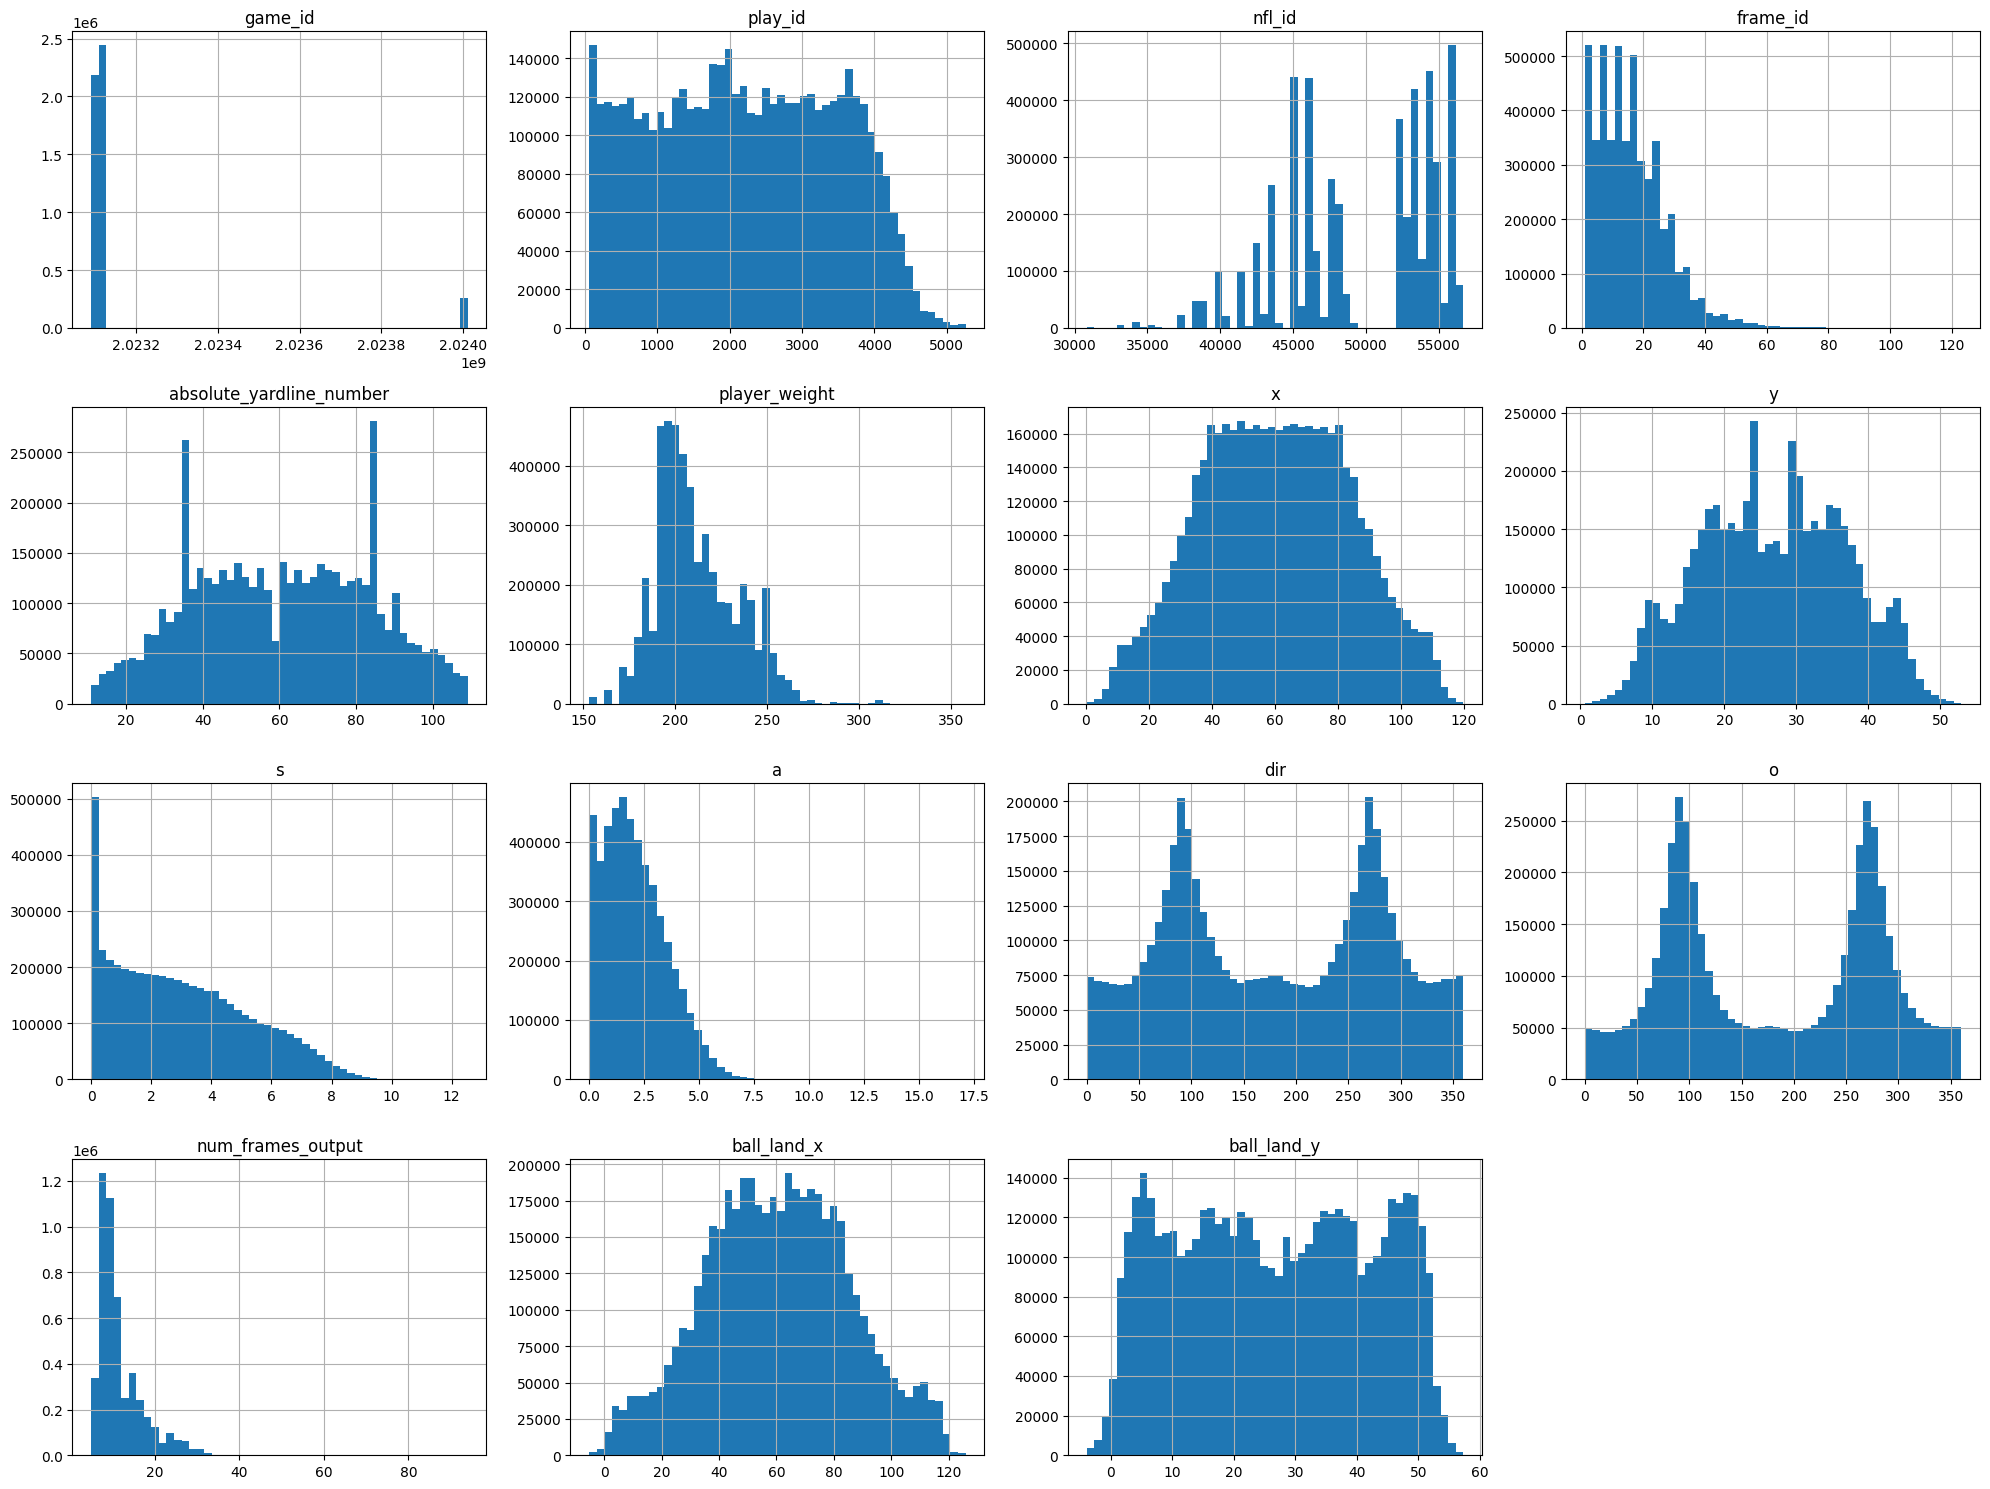

In [ ]:
train_df.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

### Correlación variables númericas

In [ ]:
corr_matrix = train_df.corr(numeric_only=True)
corr_matrix.style.background_gradient(cmap='coolwarm')

,game_id,play_id,player_to_predict,nfl_id,frame_id,absolute_yardline_number,player_weight,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
game_id,1.000000,-0.046649,-0.003291,0.018240,-0.005799,0.006925,-0.005850,0.004195,0.002696,-0.003865,-0.000483,0.002208,0.002352,0.003425,-0.000923,0.007239
play_id,-0.046649,1.000000,0.000413,0.016456,0.005741,-0.008377,-0.027185,-0.008586,-0.000180,-0.003735,-0.023165,0.000818,-0.000943,0.045453,-0.008406,-0.001256
player_to_predict,-0.003291,0.000413,1.000000,0.006374,-0.000551,0.000419,-0.025564,0.000603,-0.006011,-0.005898,-0.001004,0.000305,-0.007168,0.118172,0.000522,-0.000840
nfl_id,0.018240,0.016456,0.006374,1.000000,0.000521,-0.000295,-0.147903,0.000225,0.000361,0.035575,0.023728,-0.004477,-0.005935,0.000720,0.000538,0.000932
frame_id,-0.005799,0.005741,-0.000551,0.000521,1.000000,0.005030,0.004452,0.006850,0.002267,0.556111,0.210484,-0.002570,-0.002717,0.080511,0.006660,0.003080
absolute_yardline_number,0.006925,-0.008377,0.000419,-0.000295,0.005030,1.000000,0.003593,0.937889,-0.004579,-0.000619,0.001649,0.092848,-0.004493,-0.011060,0.841294,-0.000779
player_weight,-0.005850,-0.027185,-0.025564,-0.147903,0.004452,0.003593,1.000000,0.003312,0.002333,-0.080487,0.014764,0.002948,0.008709,-0.013794,0.003559,0.003507
x,0.004195,-0.008586,0.000603,0.000225,0.006850,0.937889,0.003312,1.000000,-0.005442,-0.002098,0.001613,-0.066573,0.131395,-0.012528,0.859600,-0.009878
y,0.002696,-0.000180,-0.006011,0.000361,0.002267,-0.004579,0.002333,-0.005442,1.000000,-0.002318,-0.001657,-0.000736,0.006594,0.000495,-0.004685,0.050480
s,-0.003865,-0.003735,-0.005898,0.035575,0.556111,-0.000619,-0.080487,-0.002098,-0.002318,1.000000,0.212926,0.002747,-0.018597,0.053797,-0.002347,-0.001241


### Análisis de variables categóricas

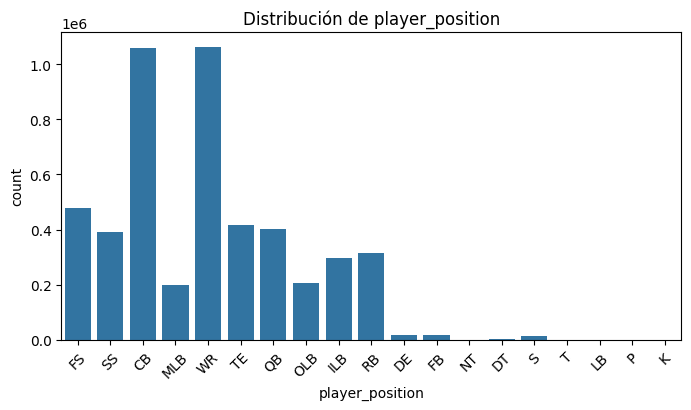

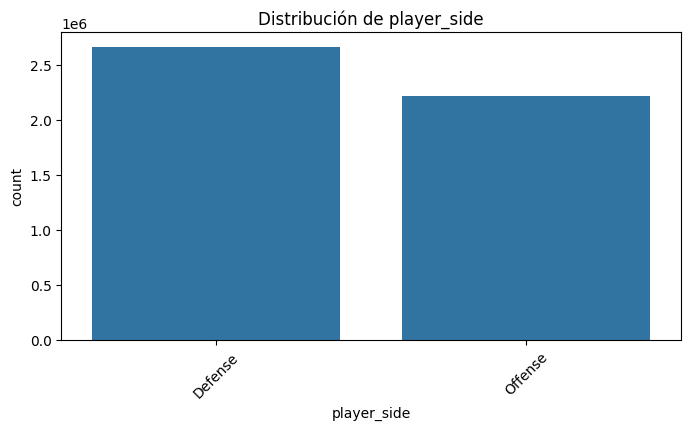

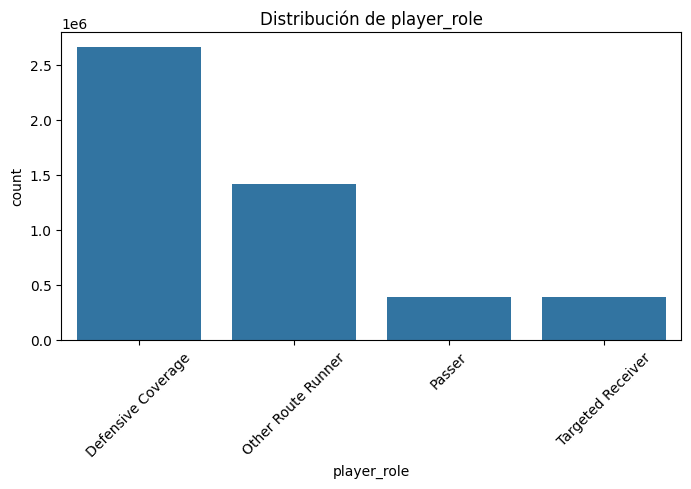

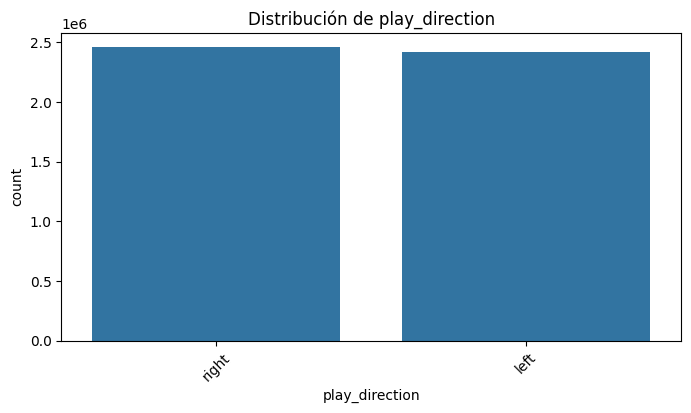

In [ ]:
cat_cols = ['player_position', 'player_side', 'player_role', 'play_direction']
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=train_df, x=col)
    plt.title(f"Distribución de {col}")
    plt.xticks(rotation=45)
    plt.show()


### Análisis espacial

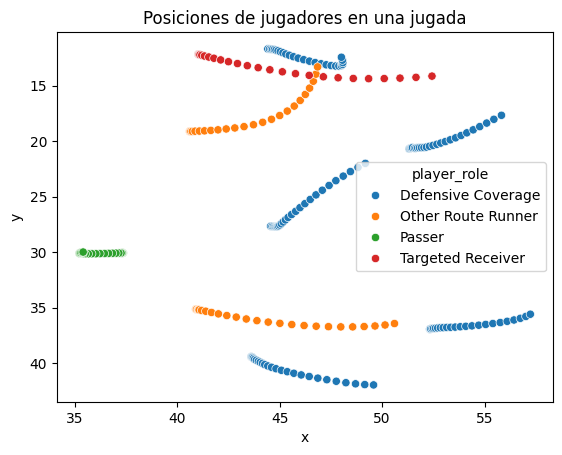

In [ ]:
sample_play = train_df[(train_df['game_id']==train_df['game_id'].iloc[0]) & (train_df['play_id']==train_df['play_id'].iloc[0])]
sns.scatterplot(data=sample_play, x='x', y='y', hue='player_role')
plt.title("Posiciones de jugadores en una jugada")
plt.gca().invert_yaxis()  # Para coincidir con orientación real del campo
plt.show()


## 4.Tratamiento de valores faltantes y codificación de categóricas

In [ ]:
train_df.isnull().sum() #Valores faltantes, en nuestro caso no tenemos

,0
game_id,0
play_id,0
player_to_predict,0
nfl_id,0
frame_id,0
play_direction,0
absolute_yardline_number,0
player_name,0
player_height,0
player_weight,0


Se implementó un esquema mixto de codificación de variables categóricas:

Label Encoding en player_name, por su alta cardinalidad (miles de jugadores únicos).

One-Hot Encoding en player_position, player_side, player_role y play_direction, dado que presentan un número reducido de categorías. Este enfoque equilibra la interpretabilidad y la eficiencia computacional, evitando la explosión dimensional asociada al One-Hot Encoding.

In [ ]:
 #Hacemos una copia de train_df en train_df_encoded debido a que vamos a codificar las variables categoricas y no queremos alterar la base original
train_df_encoded = train_df.copy()

# ===== Label Encoding =====
label_vars = ['player_name']
le = LabelEncoder()

for col in label_vars:
    train_df_encoded[col + '_encoded'] = le.fit_transform(train_df_encoded[col])
train_df_encoded['player_name'] = le.fit_transform(train_df_encoded['player_name'])

# ===== One-Hot Encoding =====
onehot_vars = ['player_position', 'player_side', 'player_role', 'play_direction']
train_df_encoded = pd.get_dummies(train_df_encoded, columns=onehot_vars, drop_first=True)

# Revisar resultado
train_df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 43 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   game_id                         int64  
 1   play_id                         int64  
 2   player_to_predict               bool   
 3   nfl_id                          int64  
 4   frame_id                        int64  
 5   absolute_yardline_number        int64  
 6   player_name                     int64  
 7   player_height                   object 
 8   player_weight                   int64  
 9   player_birth_date               object 
 10  x                               float64
 11  y                               float64
 12  s                               float64
 13  a                               float64
 14  dir                             float64
 15  o                               float64
 16  num_frames_output               int64  
 17  ball_land_x                

## 5. Ingeniería de características (Feature Engineering)
Esto es **crear nuevas variables** a partir de las **existentes**.

Para nuestro modelo vamos a utilizar la **edad del jugador**, sacandola de su **fecha de nacimiento** y vamos a **convertir la estatua a metros**

In [ ]:
# === Convertir fecha de nacimiento a datetime ===
train_df_encoded['player_birth_date'] = pd.to_datetime(train_df_encoded['player_birth_date'], errors='coerce')

# === Calcular edad (en años) ===
today = pd.Timestamp(datetime.today())
train_df_encoded['player_age'] = (today - train_df_encoded['player_birth_date']).dt.days / 365.25

# === Convertir estatura (ft-in) a metros ===
# Ejemplo de formato: "6-2" (6 pies y 2 pulgadas)
def height_to_meters(height_str):
    try:
        feet, inches = height_str.split('-')
        total_inches = int(feet) * 12 + int(inches)
        meters = total_inches * 0.0254  # 1 pulgada = 0.0254 m
        return meters
    except:
        return None  # Para valores nulos o mal formateados

train_df_encoded['player_height_m'] = train_df_encoded['player_height'].apply(height_to_meters)

# === Eliminar columnas originales no numéricas ===
train_df_encoded.drop(columns=['player_birth_date', 'player_height'], inplace=True)

# === Verificar resultado ===
train_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 43 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   game_id                         int64  
 1   play_id                         int64  
 2   player_to_predict               bool   
 3   nfl_id                          int64  
 4   frame_id                        int64  
 5   absolute_yardline_number        int64  
 6   player_name                     int64  
 7   player_weight                   int64  
 8   x                               float64
 9   y                               float64
 10  s                               float64
 11  a                               float64
 12  dir                             float64
 13  o                               float64
 14  num_frames_output               int64  
 15  ball_land_x                     float64
 16  ball_land_y                     float64
 17  player_name_encoded        

## Matriz de correlacion despues de la codificacion

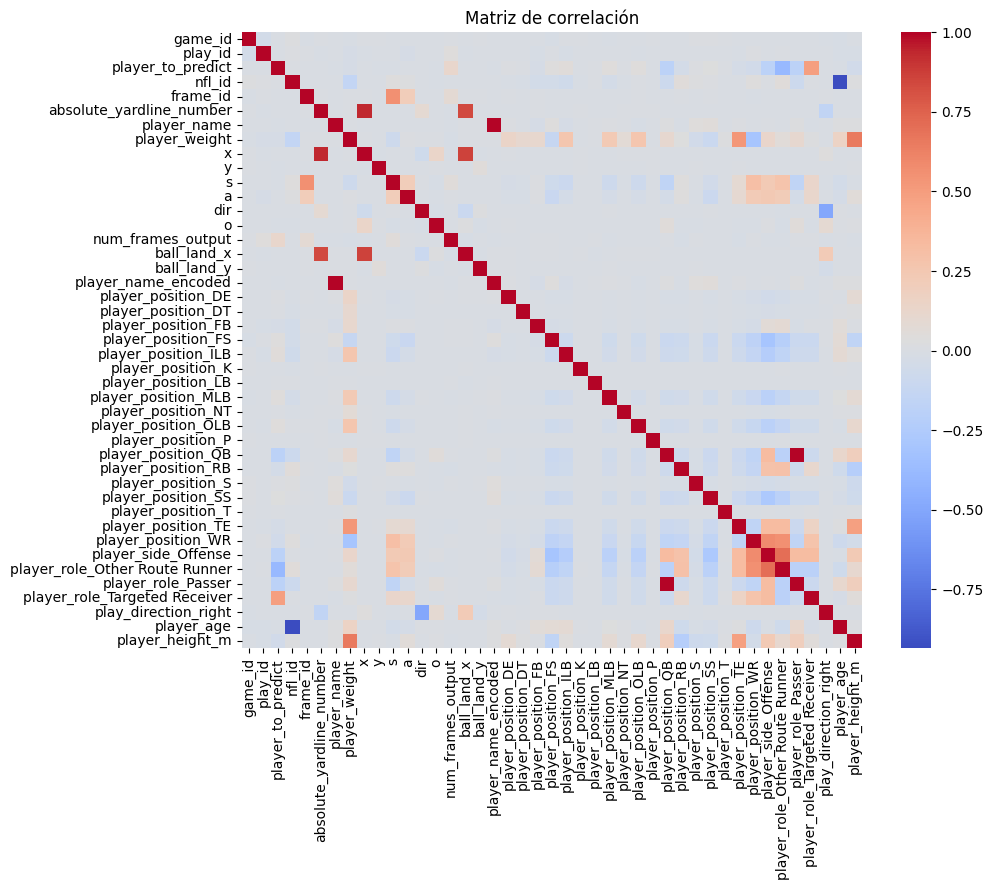

In [ ]:
corr = train_df_encoded.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

# Parte dos (Optimizacion):
### - Crear los conjuntos de entrenamiento, validación y prueba (60/20/20).
### - Implementar y comparar los modelos de regresión seleccionados.
### - Aplicar optimización bayesiana para ajustar hiperparámetros.
### - Calcular y analizar las métricas de desempeño (MAE, MSE, R², MAPE).
### - Generar conclusiones basadas en el rendimiento promedio y desviación estándar de cada modelo.

### 1. Crear los conjuntos de entrenamiento, validación y prueba (60/20/20).

In [ ]:
# ==========================================
# 🔹 Conversión segura de todos los sets a float32
# Compatible con pandas, cuDF y numpy
# ==========================================
import numpy as np
import pandas as pd
import gc

def to_float32_safe(df):
    """Convierte cualquier DataFrame, Series o array a float32 de forma segura."""
    if df is None:
        return None
    if isinstance(df, (pd.DataFrame, pd.Series)):
        return df.astype(np.float32)
    elif hasattr(df, "astype"):  # Para cuDF o numpy
        return df.astype(np.float32)
    else:
        return df  # No se puede convertir

# Lista de variables esperadas
datasets = ["X_train", "X_val", "X_test", "y_train", "y_val", "y_test"]

for name in datasets:
    if name in locals():
        print(f"🧮 Convirtiendo {name} a float32...")
        locals()[name] = to_float32_safe(locals()[name])

gc.collect()  # Limpieza de memoria

# Mostrar resumen de dtypes de X_train si existe
if "X_train" in locals():
    print("\n✅ Conversión a float32 completada.")
    print("📊 Resumen de tipos de X_train:")
    try:
        print(locals()["X_train"].dtypes.value_counts())
    except Exception:
        print("X_train no tiene atributo dtypes (posiblemente es un array o cuDF).")
else:
    print("⚠️ No se encontró X_train. Verifica tus variables.")


⚠️ No se encontró X_train. Verifica tus variables.


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# --- Supongamos que ya tienes tu dataframe procesado ---
# train_df_encoded es el dataset final tras el preprocesamiento y codificación
df = train_df_encoded.copy()

# Verificamos que existe un identificador de jugada o game_play
id_col = 'game_id'  # Use 'game_id' or a combination of 'game_id' and 'play_id' as a unique identifier

# Create a unique play identifier
df['game_play_id'] = df['game_id'].astype(str) + '_' + df['play_id'].astype(str)
id_col = 'game_play_id'


# 1️⃣ Primero dividimos a nivel de jugada (no de fila)
unique_plays = df[id_col].unique()
train_plays, temp_plays = train_test_split(unique_plays, test_size=0.4, random_state=42)
val_plays, test_plays = train_test_split(temp_plays, test_size=0.5, random_state=42)

# 2️⃣ Creamos las divisiones del dataframe original
train_df = df[df[id_col].isin(train_plays)].reset_index(drop=True)
val_df   = df[df[id_col].isin(val_plays)].reset_index(drop=True)
test_df  = df[df[id_col].isin(test_plays)].reset_index(drop=True)

# 3️⃣ Mostramos tamaños y proporciones
print("🔹 Tamaños del hold-out:")
print(f"Train: {len(train_df):,} filas ({len(train_df)/len(df):.1%})")
print(f"Validación: {len(val_df):,} filas ({len(val_df)/len(df):.1%})")
print(f"Test: {len(test_df):,} filas ({len(test_df)/len(df):.1%})")

# 4️⃣ Si ya tienes variable objetivo (y), la separamos
target_col = 'ball_land_x'  # Change this to the actual name of your dependent variable
target_col_y = 'ball_land_y'

# Check if target columns exist
if target_col in train_df.columns and target_col_y in train_df.columns:
    X_train = train_df.drop(columns=[target_col, target_col_y, id_col])
    y_train = train_df[[target_col, target_col_y]]

    X_val = val_df.drop(columns=[target_col, target_col_y, id_col])
    y_val = val_df[[target_col, target_col_y]]

    X_test = test_df.drop(columns=[target_col, target_col_y, id_col])
    y_test = test_df[[target_col, target_col_y]]

    print("\n✅ División hold-out completada.")
else:
    print(f"\n⚠️ Warning: Target columns '{target_col}' or '{target_col_y}' not found. Skipping target separation.")
    X_train = train_df.drop(columns=[id_col])
    y_train = None # Or handle missing targets as appropriate
    X_val = val_df.drop(columns=[id_col])
    y_val = None
    X_test = test_df.drop(columns=[id_col])
    y_test = None

🔹 Tamaños del hold-out:
Train: 2,929,906 filas (60.0%)
Validación: 974,781 filas (20.0%)
Test: 975,892 filas (20.0%)

✅ División hold-out completada.


### 2. Implementar y comparar los modelos de regresión seleccionados.

In [ ]:
!pip install optuna

In [ ]:
# ============================================================
# BLOQUE 1: Definición de modelos e hiperparámetros a optimizar
# ============================================================

# Importación de librerías necesarias
# -----------------------------------
# optuna: para la optimización bayesiana de hiperparámetros.
# numpy, pandas: manejo de datos numéricos y estructurados.
# sklearn: contiene implementaciones de modelos de regresión clásicos.
# xgboost: modelo basado en boosting con árboles de decisión.
# mean_absolute_error: métrica de evaluación del error absoluto medio.
import optuna
import numpy as np
import pandas as pd
from sklearn.linear_model import (
    LinearRegression, Lasso, ElasticNet, SGDRegressor, BayesianRidge
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, DotProduct
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# ------------------------------------------------------------
# Función: get_model_and_params(model_name, trial)
# ------------------------------------------------------------
# Esta función recibe el nombre de un modelo y un objeto `trial` de Optuna,
# y devuelve una instancia del modelo con los hiperparámetros sugeridos
# durante el proceso de optimización bayesiana.
# El objetivo es centralizar la definición de todos los modelos y sus espacios
# de búsqueda de hiperparámetros en una sola función.
def get_model_and_params(model_name, trial):

    # ============================================================
    # 1️⃣ Regresión Lineal
    # ============================================================
    if model_name == "LinearRegression":
        # Modelo sin hiperparámetros ajustables relevantes
        model = LinearRegression()
        return model

    # ============================================================
    # 2️⃣ LASSO (L1 Regularization)
    # ============================================================
    elif model_name == "Lasso":
        # 'alpha' controla la penalización L1 (regularización)
        alpha = trial.suggest_loguniform("alpha", 1e-6, 10)
        model = Lasso(alpha=alpha, random_state=42, max_iter=5000)
        return model

    # ============================================================
    # 3️⃣ Elastic Net (Combinación L1 + L2)
    # ============================================================
    elif model_name == "ElasticNet":
        alpha = trial.suggest_loguniform("alpha", 1e-6, 10)  # regularización total
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)  # mezcla entre L1 y L2
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42, max_iter=5000)
        return model

    # ============================================================
    # 4️⃣ Kernel Ridge Regression
    # ============================================================
    elif model_name == "KernelRidge":
        alpha = trial.suggest_loguniform("alpha", 1e-3, 10)  # regularización
        kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly"])  # tipo de núcleo
        gamma = trial.suggest_loguniform("gamma", 1e-4, 1)  # parámetro del kernel
        model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma)
        return model

    # ============================================================
    # 5️⃣ Stochastic Gradient Descent Regressor
    # ============================================================
    elif model_name == "SGDRegressor":
        alpha = trial.suggest_loguniform("alpha", 1e-6, 1e-1)  # regularización
        penalty = trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet"])  # tipo de penalización
        eta0 = trial.suggest_loguniform("eta0", 1e-4, 1e-1)  # tasa de aprendizaje inicial
        learning_rate = trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"])
        model = SGDRegressor(alpha=alpha, penalty=penalty, eta0=eta0,
                             learning_rate=learning_rate, random_state=42, max_iter=2000)
        return model

    # ============================================================
    # 6️⃣ Bayesian Ridge Regression
    # ============================================================
    elif model_name == "BayesianRidge":
        # Los hiperparámetros controlan las distribuciones previas de los coeficientes
        alpha_1 = trial.suggest_loguniform("alpha_1", 1e-8, 1)
        alpha_2 = trial.suggest_loguniform("alpha_2", 1e-8, 1)
        lambda_1 = trial.suggest_loguniform("lambda_1", 1e-8, 1)
        lambda_2 = trial.suggest_loguniform("lambda_2", 1e-8, 1)
        model = BayesianRidge(alpha_1=alpha_1, alpha_2=alpha_2,
                              lambda_1=lambda_1, lambda_2=lambda_2)
        return model

    # ============================================================
    # 7️⃣ Gaussian Process Regressor
    # ============================================================
    elif model_name == "GaussianProcessRegressor":
        alpha = trial.suggest_loguniform("alpha", 1e-10, 1e-2)  # nivel de ruido del modelo
        kernel_choice = trial.suggest_categorical("kernel", ["RBF", "DotProduct", "RationalQuadratic"])
        # Selección del kernel (función de covarianza)
        if kernel_choice == "RBF":
            kernel = RBF()
        elif kernel_choice == "DotProduct":
            kernel = DotProduct()
        else:
            kernel = RationalQuadratic()
        model = GaussianProcessRegressor(alpha=alpha, kernel=kernel, random_state=42)
        return model

    # ============================================================
    # 8️⃣ Support Vector Regressor (SVR)
    # ============================================================
    elif model_name == "SVR":
        C = trial.suggest_float("C", 1, 1000)  # penalización al error
        epsilon = trial.suggest_loguniform("epsilon", 1e-3, 0.5)  # zona de tolerancia sin penalización
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])  # tipo de kernel
        gamma = trial.suggest_loguniform("gamma", 1e-4, 1)  # parámetro del kernel
        model = SVR(C=C, epsilon=epsilon, kernel=kernel, gamma=gamma)
        return model

    # ============================================================
    # 9️⃣ Random Forest Regressor
    # ============================================================
    elif model_name == "RandomForestRegressor":
        n_estimators = trial.suggest_int("n_estimators", 100, 1000)  # número de árboles
        max_depth = trial.suggest_int("max_depth", 3, 30)  # profundidad máxima
        max_features = trial.suggest_float("max_features", 0.3, 1.0)  # proporción de variables por árbol
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)  # tamaño mínimo de hojas
        model = RandomForestRegressor(
            n_estimators=n_estimators, max_depth=max_depth,
            max_features=max_features, min_samples_leaf=min_samples_leaf,
            random_state=42, n_jobs=-1)
        return model

    # ============================================================
    # 🔟 Gradient Boosting Regressor
    # ============================================================
    elif model_name == "GradientBoostingRegressor":
        n_estimators = trial.suggest_int("n_estimators", 100, 1000)
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 0.3)
        max_depth = trial.suggest_int("max_depth", 2, 10)
        subsample = trial.suggest_float("subsample", 0.5, 1.0)  # fracción de muestras por iteración
        model = GradientBoostingRegressor(
            n_estimators=n_estimators, learning_rate=learning_rate,
            max_depth=max_depth, subsample=subsample, random_state=42)
        return model

    # ============================================================
    # 1️⃣1️⃣ XGBoost Regressor
    # ============================================================
    elif model_name == "XGBoost":
        n_estimators = trial.suggest_int("n_estimators", 100, 1000)
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 0.3)
        max_depth = trial.suggest_int("max_depth", 3, 10)
        subsample = trial.suggest_float("subsample", 0.5, 1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
        reg_lambda = trial.suggest_loguniform("lambda", 1e-6, 100)  # regularización L2
        reg_alpha = trial.suggest_loguniform("alpha", 1e-6, 100)   # regularización L1
        model = XGBRegressor(
            n_estimators=n_estimators, learning_rate=learning_rate,
            max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree,
            reg_lambda=reg_lambda, reg_alpha=reg_alpha,
            random_state=42, tree_method="hist", n_jobs=-1)
        return model



In [ ]:
# =========================================
# ⚙️ Configuración base para todas las optimizaciones
# =========================================

# ------------------------------------------------------------
# Importación de librerías
# ------------------------------------------------------------
import optuna  # Biblioteca para la optimización bayesiana de hiperparámetros
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np  # Cálculo numérico eficiente
import time  # Medición del tiempo de ejecución de cada modelo

# ------------------------------------------------------------
# Importación de modelos desde RAPIDS (GPU)
# ------------------------------------------------------------
# RAPIDS (cuML) ofrece implementaciones aceleradas por GPU de modelos clásicos,
# permitiendo reducir drásticamente los tiempos de entrenamiento.
# Solo deben usarse si el entorno de ejecución cuenta con GPU compatible (NVIDIA).
from cuml.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from cuml.svm import SVR
from cuml.ensemble import RandomForestRegressor

# ------------------------------------------------------------
# Importación de modelos CPU (Scikit-learn y XGBoost)
# ------------------------------------------------------------
# Estas implementaciones se ejecutan sobre CPU y son la referencia base
# para comparar rendimiento frente a las versiones GPU.
from sklearn.linear_model import BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# ------------------------------------------------------------
# Definición de la métrica objetivo
# ------------------------------------------------------------
# Se define una función auxiliar para calcular el error cuadrático medio (MSE),
# que mide el promedio de los errores al cuadrado entre las predicciones y los valores reales.
# Esta métrica penaliza más los errores grandes, lo cual es útil para modelos de regresión.
def score_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)



In [ ]:
# =========================================
# 📁 Inicializar archivo de guardado
# =========================================

import os  # Módulo estándar de Python para operaciones con el sistema de archivos

# Definición del nombre del archivo donde se almacenarán los mejores resultados
results_path = "best_params.txt"

# ------------------------------------------------------------
# Si el archivo de resultados ya existe, se elimina
# ------------------------------------------------------------
# Esto garantiza que en cada nueva ejecución del script, el archivo se reinicie
# y no acumule registros de ejecuciones anteriores.
if os.path.exists(results_path):
    os.remove(results_path)

# ------------------------------------------------------------
# Función: save_best_params(model_name, best_params, best_score)
# ------------------------------------------------------------
# Esta función tiene como propósito registrar en un archivo de texto:
#   - El nombre del modelo
#   - Su mejor puntuación (MSE)
#   - Los hiperparámetros óptimos encontrados durante la optimización
#
# De esta manera, se conserva un registro de los resultados obtenidos
# en cada ejecución de Optuna sin necesidad de revisar manualmente cada trial.
def save_best_params(model_name, best_params, best_score):
    """Guarda los hiperparámetros y resultados en un archivo .txt"""

    # Abre el archivo en modo 'a' (append), lo que permite agregar información
    # sin sobrescribir el contenido existente (ideal si se guardan varios modelos).
    with open(results_path, "a") as f:
        f.write(f"🔹 Modelo: {model_name}\n")
        f.write(f"📊 Mejor Score (MSE): {best_score:.6f}\n")
        f.write(f"⚙️ Hiperparámetros: {best_params}\n")
        f.write("="*70 + "\n")

    # Imprime en consola un mensaje confirmando el guardado del modelo
    print(f"✅ Parámetros de {model_name} guardados en {results_path}")



In [ ]:
import gc
import pandas as pd
import numpy as np

# ------------------------------------------------------------
# Función: clean_memory()
# ------------------------------------------------------------
# Objetivo:
#   Liberar memoria tanto en CPU como en GPU antes de comenzar un nuevo
#   entrenamiento o proceso de optimización. Esto es especialmente útil
#   cuando se ejecutan múltiples modelos en un mismo entorno (como Colab)
#   y la memoria puede llenarse fácilmente.
#
# Mecanismo:
#   1️⃣ Se invoca el recolector de basura de Python para liberar objetos no referenciados.
#   2️⃣ Si se detecta PyTorch (torch), se limpia la caché de memoria GPU.
#   3️⃣ Si se detecta CuPy (usado por RAPIDS/cuML), se libera la memoria GPU restante.
def clean_memory():
    """Libera memoria RAM y GPU antes de entrenar."""

    # 🧠 Paso 1: Limpieza de memoria en CPU
    gc.collect()  # Fuerza la recolección de basura y libera objetos no utilizados

    # ⚙️ Paso 2: Limpieza de memoria en GPU si se usa PyTorch
    try:
        import torch
        torch.cuda.empty_cache()  # Libera la memoria reservada en la GPU por PyTorch
    except:
        pass  # Si PyTorch no está instalado, simplemente continúa

    # ⚙️ Paso 3: Limpieza de memoria en GPU si se usa CuPy/RAPIDS
    try:
        import cupy as cp
        cp.get_default_memory_pool().free_all_blocks()  # Libera todos los bloques de memoria GPU de CuPy
    except:
        pass  # Si CuPy no está disponible, ignora el error

    # 🧹 Mensaje de confirmación
    print("🧹 Memoria limpiada correctamente.")

# ------------------------------------------------------------
# Ejecución inicial
# ------------------------------------------------------------
# Se recomienda realizar una limpieza de memoria antes de iniciar el proceso
# de entrenamiento o de optimización, para asegurar que los recursos del sistema
# estén completamente disponibles.
clean_memory()



🧹 Memoria limpiada correctamente.


### Rapids

In [ ]:
# ============================================================
# 🎯 Optimización bayesiana para Linear Regression
# ============================================================

def objective_lr(trial):
    """
    Función objetivo para Optuna (modelo: Linear Regression)

    Esta función define el proceso que Optuna repetirá varias veces (trials)
    con distintos conjuntos de hiperparámetros, buscando minimizar el error (MSE).
    """

    # --------------------------------------------------------
    # 1️⃣ Definición del modelo
    # --------------------------------------------------------
    # Se crea una instancia de LinearRegression con el hiperparámetro 'fit_intercept'
    # que puede tomar los valores True o False.
    # Optuna seleccionará el valor que dé mejor resultado.
    model = LinearRegression(fit_intercept=trial.suggest_categorical("fit_intercept", [True, False]))

    # --------------------------------------------------------
    # 2️⃣ Entrenamiento del modelo
    # --------------------------------------------------------
    # Se entrena el modelo con los datos de entrenamiento previamente definidos.
    model.fit(X_train, y_train)

    # --------------------------------------------------------
    # 3️⃣ Predicciones y evaluación
    # --------------------------------------------------------
    # Se generan predicciones sobre el conjunto de validación.
    preds = model.predict(X_val)

    # Se calcula el error cuadrático medio (MSE) como métrica de desempeño.
    # El objetivo de Optuna será minimizar este valor.
    return score_mse(y_val, preds)

# ============================================================
# 🧹 Limpieza de memoria antes de comenzar la optimización
# ============================================================
clean_memory()

# ============================================================
# 🚀 Configuración del estudio Optuna
# ============================================================
# Se crea un nuevo estudio en Optuna, indicando que el objetivo es "minimizar" el MSE.
study_lr = optuna.create_study(direction='minimize')

# ------------------------------------------------------------
# Ejecución de la optimización
# ------------------------------------------------------------
# - `objective_lr`: función que Optuna ejecutará en cada trial.
# - `n_trials=10`: número de combinaciones de hiperparámetros a evaluar.
# - `show_progress_bar=True`: muestra una barra de progreso visual durante la ejecución.
study_lr.optimize(objective_lr, n_trials=10, show_progress_bar=True)

# ============================================================
# 🏁 Resultados finales
# ============================================================
# Se imprimen los mejores resultados obtenidos durante la búsqueda.
print("🏁 Mejor resultado Linear Regression:", study_lr.best_value)
print("🔧 Parámetros:", study_lr.best_params)

# ============================================================
# 💾 Guardado de resultados
# ============================================================
# Los mejores hiperparámetros y su score son almacenados en el archivo `best_params.txt`
# mediante la función definida previamente.
save_best_params("Linear Regression", study_lr.best_params, study_lr.best_value)



[I 2025-10-15 00:04:29,384] A new study created in memory with name: no-name-c94aa546-958a-4605-99f9-fe5b973403bf


🧹 Memoria limpiada correctamente.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-15 00:04:52,880] Trial 0 finished with value: 2235775303.502991 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 2235775303.502991.
[I 2025-10-15 00:05:14,445] Trial 1 finished with value: 2235775303.502991 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 2235775303.502991.
[I 2025-10-15 00:05:35,528] Trial 2 finished with value: 2235775303.502991 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 2235775303.502991.
[I 2025-10-15 00:05:57,285] Trial 3 finished with value: 1135150804.3804348 and parameters: {'fit_intercept': False}. Best is trial 3 with value: 1135150804.3804348.
[I 2025-10-15 00:06:18,216] Trial 4 finished with value: 1135150804.3804348 and parameters: {'fit_intercept': False}. Best is trial 3 with value: 1135150804.3804348.
[I 2025-10-15 00:06:40,061] Trial 5 finished with value: 2235775303.502991 and parameters: {'fit_intercept': True}. Best is trial 3 with value: 1135150804.3804348.
[I 2025-10-15 0

In [ ]:
clean_memory()

🧹 Memoria limpiada correctamente.


In [ ]:
# =========================================
# 🧠 Optimización Bayesiana para modelo Lasso con multi-output
# =========================================

# Importación de librerías necesarias
import cudf                 # Librería de RAPIDS para manejar DataFrames en GPU
import numpy as np          # Librería para operaciones numéricas
import optuna               # Librería para optimización bayesiana de hiperparámetros
from cuml.linear_model import Lasso   # Implementación GPU del modelo Lasso (regresión lineal regularizada)
from sklearn.metrics import mean_squared_error  # Métrica para calcular error cuadrático medio (MSE)

# ============================================================
# 🎯 Función de puntuación personalizada: soporte para multi-output
# ============================================================
def score_mse_multioutput(y_true, y_pred):
    """
    Calcula el MSE promedio cuando existen múltiples variables objetivo (multi-output).
    Maneja casos donde las predicciones y valores reales pueden tener diferentes dimensiones.
    """

    # Asegura que los datos sean arrays de numpy
    if isinstance(y_true, (pd.DataFrame, pd.Series)):
        y_true = y_true.values
    if isinstance(y_pred, (pd.DataFrame, pd.Series)):
        y_pred = y_pred.values

    # Validación de dimensiones entre y_true e y_pred
    if y_true.shape != y_pred.shape:
        # Si las dimensiones no coinciden, se revisan los posibles motivos

        # Caso: la predicción tiene una sola dimensión, pero y_true tiene más
        if y_true.ndim == 2 and y_pred.ndim == 1:
            raise ValueError("La predicción es unidimensional, pero los valores verdaderos son bidimensionales. Verifique que el modelo prediga ambas salidas.")

        # Caso: el número de muestras no coincide
        if y_true.shape[0] != y_pred.shape[0]:
            raise ValueError(f"Desajuste en el número de muestras: y_true tiene {y_true.shape[0]}, y_pred tiene {y_pred.shape[0]}")

        # Caso: misma cantidad de filas pero diferente número de columnas (dimensión de salida)
        if y_true.ndim == 2 and y_pred.ndim == 2 and y_true.shape[1] != y_pred.shape[1]:
            print(f"⚠️ Advertencia: desajuste en dimensiones: y_true {y_true.shape}, y_pred {y_pred.shape}. Se intentará continuar si es posible.")

            # Si las predicciones tienen una sola salida cuando deberían ser dos
            if y_true.shape[1] == 2 and y_pred.shape[1] == 1:
                raise ValueError("El modelo predice solo una salida, pero se requieren dos (X e Y).")

            # Si tienen el mismo número de columnas, continúa sin error
            elif y_true.shape[1] == y_pred.shape[1]:
                pass
            else:
                raise ValueError(f"Desajuste irreconciliable entre y_true {y_true.shape} y y_pred {y_pred.shape}")

    # Caso: salida única
    if y_true.ndim == 1 or y_true.shape[1] == 1:
        return mean_squared_error(y_true, y_pred)

    # Caso: múltiples salidas → se calcula el MSE por cada salida y se promedia
    else:
        mse_x = mean_squared_error(y_true[:, 0], y_pred[:, 0])
        mse_y = mean_squared_error(y_true[:, 1], y_pred[:, 1])
        return (mse_x + mse_y) / 2.0


# ============================================================
# 🧩 Función objetivo para Optuna (entrenamiento + evaluación)
# ============================================================
def objective_lasso(trial):
    """
    Función objetivo para la optimización bayesiana con Optuna.
    Entrena dos modelos Lasso independientes (uno por cada variable objetivo)
    y devuelve el error cuadrático medio promedio (MSE).
    """

    # Hiperparámetro a optimizar → fuerza de regularización L1
    alpha = trial.suggest_float("alpha", 0.0001, 1.0, log=True)

    # Conversión explícita de las variables predictoras a numéricas
    # Se fuerzan los valores no numéricos a NaN
    X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce')
    X_val_numeric = X_val.apply(pd.to_numeric, errors='coerce')

    # Sustitución de valores faltantes por 0 para evitar errores en el entrenamiento
    X_train_numeric.fillna(0, inplace=True)
    X_val_numeric.fillna(0, inplace=True)

    # Conversión de los DataFrames a cuDF (para procesamiento en GPU)
    X_train_gpu = cudf.DataFrame.from_pandas(X_train_numeric)
    X_val_gpu = cudf.DataFrame.from_pandas(X_val_numeric)

    # Conversión de los valores reales (targets) a NumPy
    y_train_np = y_train.values if isinstance(y_train, (pd.DataFrame, pd.Series)) else y_train
    y_val_np = y_val.values if isinstance(y_val, (pd.DataFrame, pd.Series)) else y_val

    # Entrenamiento de dos modelos Lasso independientes: uno para cada salida (X e Y)
    model_x = Lasso(alpha=alpha, max_iter=1000)
    model_y = Lasso(alpha=alpha, max_iter=1000)

    # Modelo para la primera salida (X)
    y_train_x_gpu = cudf.Series(y_train_np[:, 0].astype(np.float32))
    model_x.fit(X_train_gpu, y_train_x_gpu)
    preds_x = model_x.predict(X_val_gpu)

    # Modelo para la segunda salida (Y)
    y_train_y_gpu = cudf.Series(y_train_np[:, 1].astype(np.float32))
    model_y.fit(X_train_gpu, y_train_y_gpu)
    preds_y = model_y.predict(X_val_gpu)

    # Se combinan ambas predicciones en un solo array (n_samples, 2)
    preds_combined = np.stack([preds_x.to_numpy(), preds_y.to_numpy()], axis=1)

    # Se calcula el MSE promedio entre las dos salidas
    return score_mse_multioutput(y_val_np, preds_combined)


# ============================================================
# 🧹 Limpieza de memoria antes de iniciar el estudio
# ============================================================
clean_memory()


# ============================================================
# 🚀 Creación y ejecución del estudio de optimización
# ============================================================

# Se define el estudio de Optuna, que buscará minimizar el MSE
study_lasso = optuna.create_study(direction='minimize')

# Se ejecuta la optimización durante 20 iteraciones (trials)
study_lasso.optimize(objective_lasso, n_trials=20, show_progress_bar=True)

# ============================================================
# 📊 Resultados finales del modelo
# ============================================================
print("🏁 Mejor resultado Lasso:", study_lasso.best_value)
print("🔧 Parámetros óptimos:", study_lasso.best_params)

# Guardado de los mejores parámetros en archivo externo
save_best_params("Lasso", study_lasso.best_params, study_lasso.best_value)


[I 2025-10-15 00:10:14,598] A new study created in memory with name: no-name-b715ec6c-2a3b-48ef-a636-45b8d5bb27d5


🧹 Memoria limpiada correctamente.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-15 00:10:17,316] Trial 0 finished with value: 171.35840596347524 and parameters: {'alpha': 0.5969707581692796}. Best is trial 0 with value: 171.35840596347524.
[I 2025-10-15 00:10:19,335] Trial 1 finished with value: 170.5368847191543 and parameters: {'alpha': 0.013248053223644418}. Best is trial 1 with value: 170.5368847191543.
[I 2025-10-15 00:10:20,838] Trial 2 finished with value: 170.48242340372988 and parameters: {'alpha': 0.1130682708983228}. Best is trial 2 with value: 170.48242340372988.
[I 2025-10-15 00:10:22,711] Trial 3 finished with value: 170.56932217719262 and parameters: {'alpha': 0.0012840991128769811}. Best is trial 2 with value: 170.48242340372988.
[I 2025-10-15 00:10:24,262] Trial 4 finished with value: 170.49958233062966 and parameters: {'alpha': 0.05150606678689531}. Best is trial 2 with value: 170.48242340372988.
[I 2025-10-15 00:10:28,791] Trial 5 finished with value: 170.56113894951542 and parameters: {'alpha': 0.00013268094761314413}. Best is trial 

In [ ]:
clean_memory()

🧹 Memoria limpiada correctamente.


In [ ]:
# ==========================================
# 🚀 Optimización Bayesiana: Ridge (cuML + GPU)
# ==========================================

# Importación de librerías necesarias
import cudf              # Permite manejar DataFrames en GPU mediante RAPIDS
import numpy as np       # Librería para manejo de arreglos numéricos
import optuna            # Librería de optimización bayesiana
from cuml.linear_model import Ridge  # Implementación GPU del modelo Ridge (regresión lineal con regularización L2)


# ============================================================
# 🧩 Función objetivo para Optuna (entrenamiento y evaluación)
# ============================================================
def objective_ridge(trial):
    """
    Función de optimización que entrena el modelo Ridge con un valor de regularización (alpha)
    determinado por Optuna y evalúa su desempeño en términos de error cuadrático medio (MSE).
    """

    # Hiperparámetro a optimizar: el parámetro de regularización L2
    alpha = trial.suggest_float("alpha", 1e-4, 10.0, log=True)

    # ------------------------------------------------------------
    # 🧮 Conversión de los conjuntos de entrenamiento y validación a GPU
    # ------------------------------------------------------------

    # Si los DataFrames no son de tipo cuDF, se convierten desde pandas
    X_train_gpu = cudf.DataFrame.from_pandas(X_train) if not isinstance(X_train, cudf.DataFrame) else X_train
    X_val_gpu   = cudf.DataFrame.from_pandas(X_val) if not isinstance(X_val, cudf.DataFrame) else X_val

    # Se convierten todas las columnas a tipo float32 (necesario para cuML)
    X_train_gpu = X_train_gpu.astype(np.float32)
    X_val_gpu   = X_val_gpu.astype(np.float32)

    # ------------------------------------------------------------
    # 🧠 Entrenamiento de modelos separados para cada variable objetivo (multi-output)
    # ------------------------------------------------------------

    # Se crean dos modelos Ridge independientes:
    # uno para predecir la primera salida (X) y otro para la segunda (Y)
    model_x = Ridge(alpha=alpha, fit_intercept=True)
    model_y = Ridge(alpha=alpha, fit_intercept=True)

    # Conversión de las salidas verdaderas a cuDF.Series de tipo float32
    y_train_x_gpu = cudf.Series(y_train.iloc[:, 0].astype(np.float32))
    y_train_y_gpu = cudf.Series(y_train.iloc[:, 1].astype(np.float32))

    # ------------------------------------------------------------
    # ⚙️ Entrenamiento de los modelos en GPU
    # ------------------------------------------------------------

    # Entrena el modelo para la primera salida
    model_x.fit(X_train_gpu, y_train_x_gpu)
    preds_x = model_x.predict(X_val_gpu)   # Predicciones para la primera salida

    # Entrena el modelo para la segunda salida
    model_y.fit(X_train_gpu, y_train_y_gpu)
    preds_y = model_y.predict(X_val_gpu)   # Predicciones para la segunda salida

    # ------------------------------------------------------------
    # 🔢 Combinación de predicciones para evaluar el desempeño global
    # ------------------------------------------------------------

    # Se apilan las predicciones en una matriz (n_muestras, 2)
    preds_combined = np.stack([preds_x.to_numpy(), preds_y.to_numpy()], axis=1)

    # Se convierte y_val a formato numpy para poder calcular el MSE
    y_val_np = y_val.to_numpy()

    # ------------------------------------------------------------
    # 🎯 Retornar la métrica a minimizar (Error Cuadrático Medio Promedio)
    # ------------------------------------------------------------
    return score_mse_multioutput(y_val_np, preds_combined)


# ============================================================
# 🧹 Limpieza de memoria antes del entrenamiento
# ============================================================
clean_memory()


# ============================================================
# 🚀 Creación y ejecución del estudio de optimización con Optuna
# ============================================================

# Se define el estudio que buscará minimizar el MSE
study_ridge = optuna.create_study(direction='minimize')

# Se ejecuta la optimización durante 20 pruebas (n_trials)
study_ridge.optimize(objective_ridge, n_trials=20, show_progress_bar=True)


# ============================================================
# 📊 Resultados finales
# ============================================================
print("🏁 Mejor resultado Ridge:", study_ridge.best_value)
print("🔧 Parámetros óptimos:", study_ridge.best_params)

# Guardar los resultados obtenidos por seguridad en el archivo correspondiente
save_best_params("Ridge", study_ridge.best_params, study_ridge.best_value)


[I 2025-10-15 00:12:08,739] A new study created in memory with name: no-name-d0ac77f2-e208-4cd5-a436-ef37e65a7414


🧹 Memoria limpiada correctamente.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-15 00:12:10,650] Trial 0 finished with value: 194.2105877429522 and parameters: {'alpha': 0.12837115217635328}. Best is trial 0 with value: 194.2105877429522.
[I 2025-10-15 00:12:12,239] Trial 1 finished with value: 194.2105877545045 and parameters: {'alpha': 1.1760755761839083}. Best is trial 0 with value: 194.2105877429522.
[I 2025-10-15 00:12:13,825] Trial 2 finished with value: 194.2105877545045 and parameters: {'alpha': 2.7389508650147647}. Best is trial 0 with value: 194.2105877429522.
[I 2025-10-15 00:12:15,468] Trial 3 finished with value: 194.2105877429522 and parameters: {'alpha': 0.15561818024264673}. Best is trial 0 with value: 194.2105877429522.
[I 2025-10-15 00:12:17,210] Trial 4 finished with value: 194.2105877429522 and parameters: {'alpha': 0.001855428041945004}. Best is trial 0 with value: 194.2105877429522.
[I 2025-10-15 00:12:18,788] Trial 5 finished with value: 194.2105877545045 and parameters: {'alpha': 1.2132641176076053}. Best is trial 0 with value: 1

In [ ]:
clean_memory()

🧹 Memoria limpiada correctamente.


In [ ]:
# ==============================================================
# ⚙️ Optimización Bayesiana para ElasticNet (cuML + GPU)
# ==============================================================

def objective_enet(trial):
    """
    Función objetivo para Optuna que entrena el modelo ElasticNet (versión GPU de cuML)
    y busca los mejores hiperparámetros para minimizar el error cuadrático medio (MSE).
    """

    # ------------------------------------------------------------
    # 🎯 Definición de los hiperparámetros a optimizar
    # ------------------------------------------------------------
    # alpha → controla la fuerza de la regularización (L1 + L2)
    # l1_ratio → define la proporción entre L1 (Lasso) y L2 (Ridge)
    alpha = trial.suggest_float("alpha", 0.0001, 1.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    # ------------------------------------------------------------
    # 🧮 Conversión y limpieza de los datos de entrada
    # ------------------------------------------------------------
    # Se convierten los DataFrames de pandas a cuDF para entrenamiento en GPU.
    # Además, se fuerzan los valores a numéricos, reemplazando los no válidos por 0
    # y usando el tipo float32 (requerido por cuML).
    X_train_gpu = cudf.DataFrame.from_pandas(
        X_train.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
    )
    X_val_gpu = cudf.DataFrame.from_pandas(
        X_val.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
    )

    # ------------------------------------------------------------
    # 🧠 Preparación de las variables objetivo (y)
    # ------------------------------------------------------------
    # Se convierten las variables de salida a formato NumPy (si aún no lo están).
    # Esto facilita su manejo y compatibilidad con cuML y las métricas.
    y_train_np = y_train.values if isinstance(y_train, (pd.DataFrame, pd.Series)) else y_train
    y_val_np = y_val.values if isinstance(y_val, (pd.DataFrame, pd.Series)) else y_val

    # ------------------------------------------------------------
    # 🤖 Entrenamiento de modelos independientes para cada salida
    # ------------------------------------------------------------
    # ElasticNet no siempre soporta salidas múltiples directamente,
    # por lo tanto, entrenamos dos modelos: uno para la componente X y otro para Y.
    model_x = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=1000)
    model_y = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=1000)

    # Convertimos las salidas de entrenamiento a formato cuDF.Series (GPU-friendly)
    y_train_x_gpu = cudf.Series(y_train_np[:, 0].astype(np.float32))
    y_train_y_gpu = cudf.Series(y_train_np[:, 1].astype(np.float32))

    # ------------------------------------------------------------
    # 🏋️ Entrenamiento y predicción de los modelos
    # ------------------------------------------------------------

    # Modelo para la primera salida (X)
    model_x.fit(X_train_gpu, y_train_x_gpu)
    preds_x = model_x.predict(X_val_gpu)

    # Modelo para la segunda salida (Y)
    model_y.fit(X_train_gpu, y_train_y_gpu)
    preds_y = model_y.predict(X_val_gpu)

    # ------------------------------------------------------------
    # 🔢 Combinación de las predicciones en un solo arreglo
    # ------------------------------------------------------------
    # Se apilan las predicciones en una matriz de forma (n_muestras, 2)
    preds_combined = np.stack([preds_x.to_numpy(), preds_y.to_numpy()], axis=1)

    # Aseguramos que y_val también esté en formato NumPy
    y_val_np = y_val.to_numpy()

    # ------------------------------------------------------------
    # 🎯 Cálculo del error cuadrático medio combinado
    # ------------------------------------------------------------
    # Se utiliza la función personalizada que promedia el MSE entre ambas salidas
    return score_mse_multioutput(y_val_np, preds_combined)


# ==============================================================
# 🚀 Ejecución de la optimización con Optuna
# ==============================================================

# Se crea el estudio de Optuna, indicando que queremos minimizar el error
study_enet = optuna.create_study(direction='minimize')

# Se ejecuta la optimización por 20 iteraciones (trials)
study_enet.optimize(objective_enet, n_trials=20, show_progress_bar=True)

# ==============================================================
# 📊 Resultados finales
# ==============================================================

# Imprimir el mejor valor de MSE encontrado
print("🏁 Mejor resultado ElasticNet:", study_enet.best_value)

# Imprimir los mejores hiperparámetros encontrados
print("🔧 Parámetros:", study_enet.best_params)

# Guardar los resultados en el archivo de registro
save_best_params("ElasticNet", study_enet.best_params, study_enet.best_value)


[I 2025-10-15 00:14:02,500] A new study created in memory with name: no-name-a819a059-eade-483c-ab11-8be622a2b360


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-15 00:14:04,895] Trial 0 finished with value: 170.72691743376055 and parameters: {'alpha': 0.034390065228726806, 'l1_ratio': 0.5003819336671527}. Best is trial 0 with value: 170.72691743376055.
[I 2025-10-15 00:14:06,982] Trial 1 finished with value: 173.85479648844097 and parameters: {'alpha': 0.19892341477996348, 'l1_ratio': 0.5453158826377664}. Best is trial 0 with value: 170.72691743376055.
[I 2025-10-15 00:14:08,741] Trial 2 finished with value: 170.60898771649016 and parameters: {'alpha': 0.03758458365066029, 'l1_ratio': 0.7140196253321388}. Best is trial 2 with value: 170.60898771649016.
[I 2025-10-15 00:14:10,444] Trial 3 finished with value: 170.8180987238849 and parameters: {'alpha': 0.11529880298644919, 'l1_ratio': 0.848563629557156}. Best is trial 2 with value: 170.60898771649016.
[I 2025-10-15 00:14:12,390] Trial 4 finished with value: 170.56345783330428 and parameters: {'alpha': 0.0016947928688367403, 'l1_ratio': 0.1066881279199221}. Best is trial 4 with value:

In [ ]:
clean_memory()

🧹 Memoria limpiada correctamente.


In [ ]:
# ==========================================
# ⚡ Optimización Bayesiana: LinearSVR (cuML + GPU)
# ==========================================
import cudf               # Manejo de DataFrames en GPU (similar a pandas, pero para CUDA)
import cupy as cp          # Arrays de GPU (similar a numpy, pero en CUDA)
import numpy as np
import optuna              # Librería para optimización bayesiana de hiperparámetros
from cuml.svm import LinearSVR  # Implementación GPU de LinearSVR (cuML)
import pandas as pd        # Para manejo inicial de datos en CPU

# ------------------------------------------
# 🧮 Función de evaluación: error cuadrático medio multi-output
# ------------------------------------------
def score_mse_multioutput(y_true, y_pred):
    """
    Calcula el error cuadrático medio (MSE) para problemas con múltiples salidas (multi-output).
    Si hay más de una variable objetivo (por ejemplo, coordenadas X e Y),
    promedia los errores de cada una.
    """

    # Aseguramos que los datos estén en formato numpy
    if isinstance(y_true, (pd.DataFrame, pd.Series)):
        y_true = y_true.values
    if isinstance(y_pred, (pd.DataFrame, pd.Series)):
        y_pred = y_pred.values

    # Validación de dimensiones
    if y_true.shape != y_pred.shape:
        # Verificación de errores comunes de forma
        if y_true.ndim == 2 and y_pred.ndim == 1:
            raise ValueError("Predicción 1D pero los valores verdaderos son 2D — falta una salida del modelo.")
        if y_true.shape[0] != y_pred.shape[0]:
            raise ValueError(f"Cantidad de muestras distintas: y_true={y_true.shape[0]}, y_pred={y_pred.shape[0]}")
        if y_true.ndim == 2 and y_pred.ndim == 2 and y_true.shape[1] != y_pred.shape[1]:
            raise ValueError(f"Dimensiones incompatibles entre y_true {y_true.shape} y y_pred {y_pred.shape}")

    # Caso de una sola salida
    if y_true.ndim == 1 or y_true.shape[1] == 1:
        return mean_squared_error(y_true, y_pred)
    else:
        # Caso multi-output: promedio de MSE por variable
        mse_x = mean_squared_error(y_true[:, 0], y_pred[:, 0])
        mse_y = mean_squared_error(y_true[:, 1], y_pred[:, 1])
        return (mse_x + mse_y) / 2.0


# ------------------------------------------
# 🧠 Función objetivo para Optuna
# ------------------------------------------
def objective_linear_svr(trial):
    """
    Función de evaluación para Optuna que entrena y evalúa un modelo LinearSVR con GPU.
    Optuna ajusta los hiperparámetros 'C' y 'epsilon' para minimizar el MSE.
    """

    # Hiperparámetros a optimizar (definidos por búsqueda bayesiana)
    C = trial.suggest_float("C", 0.1, 10.0, log=True)
    epsilon = trial.suggest_float("epsilon", 0.001, 1.0, log=True)

    # Conversión de datos a formato cuDF (GPU) y float32
    X_train_gpu = cudf.DataFrame.from_pandas(
        X_train.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
    )
    X_val_gpu = cudf.DataFrame.from_pandas(
        X_val.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
    )

    # Conversiones para y (objetivo)
    y_train_np = np.asarray(y_train, dtype=np.float32)
    y_val_np = np.asarray(y_val, dtype=np.float32)

    # ------------------------------------------
    # Caso 1️⃣: problema multi-output (por ejemplo, predicción de dos coordenadas)
    # ------------------------------------------
    if y_train_np.ndim == 2 and y_train_np.shape[1] > 1:
        preds_list = []

        # Entrenar un modelo independiente por cada salida
        for i in range(y_train_np.shape[1]):
            y_train_col = cudf.Series(y_train_np[:, i])
            model = LinearSVR(C=C, epsilon=epsilon, max_iter=1000)
            model.fit(X_train_gpu, y_train_col)
            preds = model.predict(X_val_gpu)
            preds_list.append(preds.to_numpy())

        # Combinar predicciones y evaluar con función multi-output
        preds_combined = np.stack(preds_list, axis=1)
        return score_mse_multioutput(y_val_np, preds_combined)

    # ------------------------------------------
    # Caso 2️⃣: problema single-output (una sola variable objetivo)
    # ------------------------------------------
    else:
        y_train_gpu = cudf.Series(y_train_np)
        y_val_gpu = cudf.Series(y_val_np)

        model = LinearSVR(C=C, epsilon=epsilon, max_iter=1000)
        model.fit(X_train_gpu, y_train_gpu)
        preds = model.predict(X_val_gpu)

        preds_np = preds.to_numpy()
        y_val_np = y_val_gpu.to_numpy()

        return score_mse(y_val_np, preds_np)


# ------------------------------------------
# 🔍 Creación y ejecución del estudio de Optuna
# ------------------------------------------
study_linear_svr = optuna.create_study(direction='minimize')
study_linear_svr.optimize(objective_linear_svr, n_trials=20, show_progress_bar=True)

# ------------------------------------------
# 📊 Resultados finales
# ------------------------------------------
print("🏁 Mejor resultado LinearSVR:", study_linear_svr.best_value)
print("🔧 Parámetros óptimos:", study_linear_svr.best_params)

# Guardar resultados en un registro global (por ejemplo, diccionario o archivo)
save_best_params("LinearSVR", study_linear_svr.best_params, study_linear_svr.best_value)


[I 2025-10-15 00:27:17,712] A new study created in memory with name: no-name-84478183-a779-4ad9-896c-c341382a652a


  0%|          | 0/20 [00:00<?, ?it/s]

[2025-10-15 00:27:19.531] [CUML] [warning] L-BFGS line search failed (code 4); stopping at the last valid step
[2025-10-15 00:27:19.753] [CUML] [warning] L-BFGS line search failed (code 4); stopping at the last valid step
[I 2025-10-15 00:27:19,857] Trial 0 finished with value: 2269.925910949707 and parameters: {'C': 9.422979066674971, 'epsilon': 0.12952376331968113}. Best is trial 0 with value: 2269.925910949707.
[2025-10-15 00:27:22.948] [CUML] [warning] L-BFGS line search failed (code 4); stopping at the last valid step
[2025-10-15 00:27:23.137] [CUML] [warning] L-BFGS line search failed (code 4); stopping at the last valid step
[I 2025-10-15 00:27:23,160] Trial 1 finished with value: 2269.925910949707 and parameters: {'C': 2.84091193851228, 'epsilon': 0.033450504292155556}. Best is trial 0 with value: 2269.925910949707.
[2025-10-15 00:27:24.844] [CUML] [warning] L-BFGS line search failed (code 4); stopping at the last valid step
[2025-10-15 00:27:25.025] [CUML] [warning] L-BFGS lin

In [ ]:
clean_memory()

In [ ]:
# ==========================================
# ⚡ Optimización Bayesiana: RandomForestRegressor (cuML + GPU)
# ==========================================
import cudf                 # Manejo de DataFrames en GPU (alternativa de pandas para CUDA)
import cupy as cp           # Numpy en GPU
import numpy as np
import optuna               # Librería para optimización bayesiana
from cuml.ensemble import RandomForestRegressor  # Random Forest acelerado en GPU
import pandas as pd
from sklearn.metrics import mean_squared_error   # Métrica de evaluación

# ------------------------------------------
# 🎯 Función de puntuación para salida múltiple
# ------------------------------------------
def score_mse_multioutput(y_true, y_pred):
    """
    Calcula el Error Cuadrático Medio (MSE) para modelos con múltiples salidas.
    En caso de tener más de una variable objetivo (por ejemplo, coordenadas X e Y),
    se calcula el MSE por cada una y se obtiene el promedio.
    """

    # Convertir posibles DataFrames/Series a arreglos numpy
    if isinstance(y_true, (pd.DataFrame, pd.Series)):
        y_true = y_true.values
    if isinstance(y_pred, (pd.DataFrame, pd.Series)):
        y_pred = y_pred.values

    # Validación de dimensiones
    if y_true.shape != y_pred.shape:
        if y_true.ndim == 2 and y_pred.ndim == 1:
            raise ValueError("Prediction is 1D, but true values are 2D.")
        if y_true.shape[0] != y_pred.shape[0]:
            raise ValueError(f"Shape mismatch: y_true {y_true.shape[0]}, y_pred {y_pred.shape[0]}")

    # Si solo hay una salida
    if y_true.ndim == 1 or y_true.shape[1] == 1:
        return mean_squared_error(y_true, y_pred)
    else:
        # Si hay dos salidas, se calcula el MSE por cada componente y se promedia
        mse_x = mean_squared_error(y_true[:, 0], y_pred[:, 0])
        mse_y = mean_squared_error(y_true[:, 1], y_pred[:, 1])
        return (mse_x + mse_y) / 2.0


# ------------------------------------------
# 🧠 Función objetivo para Optuna
# ------------------------------------------
def objective_rf(trial):
    """
    Función objetivo para Optuna.
    Entrena un modelo RandomForestRegressor con distintos hiperparámetros
    y devuelve el MSE promedio sobre el conjunto de validación.
    """

    # Hiperparámetros a optimizar
    n_estimators = trial.suggest_int("n_estimators", 100, 500)  # Nº de árboles
    max_depth = trial.suggest_int("max_depth", 3, 15)           # Profundidad máxima del árbol

    # Convertir los conjuntos de entrenamiento y validación a formato GPU (cuDF)
    X_train_gpu = cudf.DataFrame.from_pandas(
        X_train.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
    )
    X_val_gpu = cudf.DataFrame.from_pandas(
        X_val.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
    )

    # Convertir las salidas a numpy de 32 bits
    y_train_np = np.asarray(y_train, dtype=np.float32)
    y_val_np = np.asarray(y_val, dtype=np.float32)

    # ------------------------------------------
    # 🔀 Entrenamiento multioutput (dos salidas)
    # ------------------------------------------
    # Se entrena un modelo independiente para cada componente de la salida
    model_x = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )
    model_y = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    # Conversión de etiquetas por salida a GPU
    y_train_x_gpu = cudf.Series(y_train_np[:, 0])
    y_train_y_gpu = cudf.Series(y_train_np[:, 1])

    # Entrenamiento y predicción por componente
    model_x.fit(X_train_gpu, y_train_x_gpu)
    preds_x = model_x.predict(X_val_gpu)

    model_y.fit(X_train_gpu, y_train_y_gpu)
    preds_y = model_y.predict(X_val_gpu)

    # Combinar ambas predicciones para evaluar el desempeño conjunto
    preds_combined = np.stack([preds_x.to_numpy(), preds_y.to_numpy()], axis=1)

    # Devolver el MSE promedio como métrica a minimizar
    return score_mse_multioutput(y_val_np, preds_combined)


# ------------------------------------------
# 🔍 Ejecución del estudio con Optuna
# ------------------------------------------
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=10, show_progress_bar=True)

# ------------------------------------------
# 📊 Resultados finales
# ------------------------------------------
print("🏁 Mejor resultado RandomForest:", study_rf.best_value)
print("🔧 Parámetros óptimos:", study_rf.best_params)

# Guardar los parámetros óptimos y su rendimiento
save_best_params("RandomForest", study_rf.best_params, study_rf.best_value)

[I 2025-10-15 01:05:42,632] A new study created in memory with name: no-name-84ef1aea-f421-406e-9b5f-554a202ade14


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-15 01:08:36,138] Trial 0 finished with value: 111.59405708312988 and parameters: {'n_estimators': 316, 'max_depth': 14}. Best is trial 0 with value: 111.59405708312988.
[I 2025-10-15 01:11:46,483] Trial 1 finished with value: 130.74019241333008 and parameters: {'n_estimators': 425, 'max_depth': 10}. Best is trial 0 with value: 111.59405708312988.
[I 2025-10-15 01:15:10,474] Trial 2 finished with value: 124.43309020996094 and parameters: {'n_estimators': 434, 'max_depth': 11}. Best is trial 0 with value: 111.59405708312988.
[I 2025-10-15 01:16:45,691] Trial 3 finished with value: 111.49334526062012 and parameters: {'n_estimators': 170, 'max_depth': 14}. Best is trial 3 with value: 111.49334526062012.
[I 2025-10-15 01:20:27,890] Trial 4 finished with value: 124.67086601257324 and parameters: {'n_estimators': 472, 'max_depth': 11}. Best is trial 3 with value: 111.49334526062012.
[I 2025-10-15 01:23:21,886] Trial 5 finished with value: 252.98133850097656 and parameters: {'n_esti

In [ ]:
clean_memory()

### CPU

In [ ]:
# ==========================================
# 🧠 Optimización Bayesiana: Bayesian Ridge Regression (CPU)
# ==========================================
import optuna
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
import pandas as pd  # Asegura compatibilidad con los DataFrames usados

# ------------------------------------------
# 🎯 Función de puntuación para salida múltiple
# ------------------------------------------
def score_mse_multioutput(y_true, y_pred):
    """
    Calcula el Error Cuadrático Medio (MSE) promedio para problemas de múltiples salidas.
    Permite evaluar modelos que predicen más de una variable objetivo (por ejemplo: coordenadas X e Y).
    """

    # Convertir posibles DataFrames o Series a arrays de NumPy
    if isinstance(y_true, (pd.DataFrame, pd.Series)):
        y_true = y_true.values
    if isinstance(y_pred, (pd.DataFrame, pd.Series)):
        y_pred = y_pred.values

    # Validar que las dimensiones de verdad y predicción sean iguales
    if y_true.shape != y_pred.shape:
        if y_true.ndim == 2 and y_pred.ndim == 1:
            raise ValueError("La predicción es 1D, pero los valores verdaderos son 2D.")
        if y_true.shape[0] != y_pred.shape[0]:
            raise ValueError(f"Dimensiones incompatibles: y_true {y_true.shape[0]}, y_pred {y_pred.shape[0]}")
        if y_true.ndim == 2 and y_pred.ndim == 2 and y_true.shape[1] != y_pred.shape[1]:
            print(f"⚠️ Advertencia: diferencia en el número de columnas: y_true {y_true.shape}, y_pred {y_pred.shape}")
            raise ValueError("Las dimensiones de salida no coinciden.")

    # Caso de una sola salida
    if y_true.ndim == 1 or y_true.shape[1] == 1:
        return mean_squared_error(y_true, y_pred)
    else:
        # Caso multisalida: se calcula el MSE por cada columna y luego se promedia
        mse_x = mean_squared_error(y_true[:, 0], y_pred[:, 0])
        mse_y = mean_squared_error(y_true[:, 1], y_pred[:, 1])
        return (mse_x + mse_y) / 2.0


# ------------------------------------------
# ⚙️ Función objetivo para Optuna
# ------------------------------------------
def objective_bayes(trial):
    """
    Define el proceso de optimización de hiperparámetros para el modelo BayesianRidge.
    Entrena modelos separados para cada variable de salida (por ejemplo, X e Y).
    """

    # Hiperparámetros a optimizar mediante búsqueda bayesiana
    alpha_1 = trial.suggest_float("alpha_1", 1e-7, 1e-3, log=True)   # Prior sobre el parámetro alpha
    lambda_1 = trial.suggest_float("lambda_1", 1e-7, 1e-3, log=True) # Prior sobre el parámetro lambda

    # Crear dos modelos independientes para cada componente de la salida
    model_x = BayesianRidge(alpha_1=alpha_1, lambda_1=lambda_1)
    model_y = BayesianRidge(alpha_1=alpha_1, lambda_1=lambda_1)

    # Entrenar modelo para la primera variable (X)
    model_x.fit(X_train, y_train.iloc[:, 0])
    preds_x = model_x.predict(X_val)

    # Entrenar modelo para la segunda variable (Y)
    model_y.fit(X_train, y_train.iloc[:, 1])
    preds_y = model_y.predict(X_val)

    # Combinar las predicciones de ambas salidas en una sola matriz
    preds_combined = np.stack([preds_x, preds_y], axis=1)

    # Calcular el MSE combinado
    return score_mse_multioutput(y_val.to_numpy(), preds_combined)


# ------------------------------------------
# 🔍 Ejecución del estudio de Optuna
# ------------------------------------------
study_bayes = optuna.create_study(direction='minimize')
study_bayes.optimize(objective_bayes, n_trials=15, show_progress_bar=True)

# ------------------------------------------
# 📊 Resultados finales
# ------------------------------------------
print("🏁 Mejor resultado BayesianRidge:", study_bayes.best_value)
print("🔧 Parámetros óptimos:", study_bayes.best_params)

# Guardar los mejores parámetros obtenidos
save_best_params("BayesianRidge", study_bayes.best_params, study_bayes.best_value)

In [ ]:
clean_memory()

In [ ]:
'''
# ==========================================
# 🧠 Optimización Bayesiana: Kernel Ridge
# ==========================================
from sklearn.kernel_ridge import KernelRidge

def objective_kernel_ridge(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])
    gamma = trial.suggest_float("gamma", 1e-4, 1.0, log=True)

    model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return score_mse(y_val, preds)

study_kr = optuna.create_study(direction='minimize')
study_kr.optimize(objective_kernel_ridge, n_trials=25, show_progress_bar=True)

print("🏁 Mejor resultado Kernel Ridge:", study_kr.best_value)
print("🔧 Parámetros:", study_kr.best_params)

save_best_params("KernelRidge", study_kr.best_params, study_kr.best_value)
'''

[I 2025-10-14 21:15:23,736] A new study created in memory with name: no-name-94e6f306-d1b1-4508-b1e0-57ddeabfdea6


  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
clean_memory()

In [ ]:
# ==========================================
# ==========================================
# 🌌 Optimización Bayesiana: Gaussian Process Regressor (versión segura)
# ==========================================
import gc
import numpy as np
import pandas as pd
import optuna
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic

# 🧩 Reducir tamaño de dataset para evitar explosión de RAM
def get_small_sample(X, y, frac=0.25):
    """
    Esta función toma una fracción del dataset original para evitar problemas de memoria
    o lentitud extrema durante el entrenamiento del modelo Gaussian Process.
    Los Gaussian Process escalan muy mal con el número de muestras (> 5000 puntos puede ser problemático).
    """
    if len(X) > 5000:
        # Si el dataset tiene más de 5000 filas, se toma una muestra aleatoria del 25%
        X_sample = X.sample(frac=frac, random_state=42)
        y_sample = y.loc[X_sample.index]
    else:
        # Si el dataset es pequeño, se usa completo
        X_sample, y_sample = X, y
    return X_sample, y_sample

# 📉 Aplicar reducción a los conjuntos de entrenamiento y validación
X_train_small, y_train_small = get_small_sample(X_train, y_train)
X_val_small, y_val_small = get_small_sample(X_val, y_val)

# 🌌 Definir la función objetivo de Optuna
def objective_gp(trial):
    """
    Función objetivo que Optuna usará para probar diferentes configuraciones del modelo.
    Retorna el error cuadrático medio (MSE) para cada conjunto de hiperparámetros.
    """

    # Optuna probará distintos tipos de kernel
    kernel_choice = trial.suggest_categorical(
        "kernel", ["RBF", "Matern", "RationalQuadratic"]
    )

    # El parámetro length_scale controla la suavidad de la función del kernel
    length_scale = trial.suggest_float("length_scale", 0.1, 10.0, log=True)

    # Selección del kernel según el valor elegido por Optuna
    if kernel_choice == "RBF":
        kernel = RBF(length_scale=length_scale)
    elif kernel_choice == "Matern":
        kernel = Matern(length_scale=length_scale, nu=1.5)
    else:
        kernel = RationalQuadratic(length_scale=length_scale, alpha=1.0)

    # ⚙️ Configurar el modelo Gaussian Process
    model = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=1,  # reduce el tiempo de optimización (menos reinicios)
        alpha=1e-3,              # agrega un término de ruido para evitar singularidades numéricas
        normalize_y=True          # normaliza las etiquetas (ayuda en datasets no centrados)
    )

    # Entrenar el modelo con el dataset reducido
    model.fit(X_train_small, y_train_small)

    # Realizar predicciones sobre el conjunto de validación reducido
    preds = model.predict(X_val_small)

    # Calcular el MSE con la función score_mse definida previamente
    return score_mse(y_val_small, preds)

# 🚀 Limpieza antes de ejecutar
clean_memory()  # Libera memoria de CPU y GPU antes de iniciar el estudio

# 🎯 Crear estudio Optuna para minimizar el MSE
study_gp = optuna.create_study(direction='minimize')

# Ejecutar optimización con 8 pruebas (trials)
# Se usa n_jobs=1 para evitar errores de concurrencia o sobrecarga de memoria
study_gp.optimize(objective_gp, n_trials=8, n_jobs=1, show_progress_bar=True)

# 🏁 Mostrar resultados del mejor modelo
print("🏁 Mejor resultado Gaussian Process:", study_gp.best_value)
print("🔧 Parámetros:", study_gp.best_params)

# 💾 Guardar resultados para registro posterior
save_best_params("GaussianProcessRegressor", study_gp.best_params, study_gp.best_value)

# 🧹 Limpieza final de memoria
clean_memory()

[I 2025-10-14 23:33:05,101] A new study created in memory with name: no-name-b62e29b4-b75a-4cc7-80d4-595b59271d72


🧹 Memoria limpiada correctamente.


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
clean_memory()

In [ ]:
# ==========================================
# ⚡ OPTIMIZACIÓN BAYESIANA: XGBoost (CPU)
# ==========================================
# En este script se utiliza la librería Optuna para realizar la optimización bayesiana
# de los hiperparámetros del modelo XGBoost (versión CPU). El objetivo es encontrar
# la mejor configuración que minimice el error cuadrático medio (MSE) en un conjunto
# de validación, manteniendo eficiencia en el uso de memoria.

# ------------------------------------------------------
# 📦 Importación de librerías necesarias
# ------------------------------------------------------
import gc                      # Permite la recolección manual de basura (limpieza de memoria)
import optuna                  # Librería para optimización automática de hiperparámetros
import numpy as np             # Manipulación numérica
import pandas as pd            # Manipulación de datos tabulares
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping  # (Opcional) Callback para detener entrenamiento si no mejora

# ------------------------------------------------------
# 🧩 Función para reducir el tamaño del dataset
# ------------------------------------------------------
def get_small_sample(X, y, frac=0.3, max_rows=10000):
    """
    Toma una muestra del conjunto de datos original para acelerar el proceso de optimización.
    Esto permite que cada prueba de Optuna se ejecute más rápido sin necesidad de usar
    el 100% de los datos.
    - frac: porcentaje de filas a tomar si el dataset es pequeño.
    - max_rows: límite máximo de filas para datasets grandes.
    """
    if len(X) > max_rows:
        # Si el dataset es muy grande, se toman máximo 10,000 filas aleatorias.
        X_sample = X.sample(n=max_rows, random_state=42, replace=False)
        y_sample = y.loc[X_sample.index]
    else:
        # Si no es tan grande, se toma una fracción (por defecto, 30%).
        X_sample = X.sample(frac=frac, random_state=42, replace=False)
        y_sample = y.loc[X_sample.index]
    return X_sample, y_sample

# ------------------------------------------------------
# 🔹 Creación de subconjuntos reducidos de entrenamiento y validación
# ------------------------------------------------------
# Esto hace que la optimización bayesiana sea más liviana y rápida.
X_train_small, y_train_small = get_small_sample(X_train, y_train)
X_val_small, y_val_small = get_small_sample(X_val, y_val)

# ------------------------------------------------------
# 🎯 Función objetivo para Optuna
# ------------------------------------------------------
def objective_xgb(trial):
    """
    Define los hiperparámetros que serán optimizados por Optuna.
    Cada 'trial' representa una combinación diferente de parámetros.
    La función devuelve el valor del MSE obtenido en validación, que es la métrica a minimizar.
    """
    # 🔧 Espacio de búsqueda de hiperparámetros
    params = {
        "tree_method": "hist",          # Implementación eficiente para CPU
        "predictor": "cpu_predictor",   # Fuerza el uso de CPU (no GPU)
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),  # Tasa de aprendizaje
        "max_depth": trial.suggest_int("max_depth", 3, 9),                          # Profundidad máxima de los árboles
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),                   # Fracción de muestras usadas en cada árbol
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),     # Fracción de características usadas
        "n_estimators": trial.suggest_int("n_estimators", 80, 300),                # Número de árboles
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),     # Regularización L2
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),       # Regularización L1
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),          # Peso mínimo por nodo hoja
        "verbosity": 0,                                                            # Silencia mensajes internos
        "random_state": 42                                                         # Semilla para reproducibilidad
    }

    # ⚙️ Entrenamiento del modelo con los parámetros propuestos
    model = XGBRegressor(**params)

    model.fit(
        X_train_small,                      # Datos de entrenamiento reducidos
        y_train_small,                      # Etiquetas correspondientes
        eval_set=[(X_val_small, y_val_small)],  # Conjunto de validación para evaluación interna
        verbose=False
    )

    # 🔍 Predicción sobre el conjunto de validación
    preds = model.predict(X_val_small)

    # 📏 Cálculo del error cuadrático medio (MSE)
    score = score_mse(y_val_small, preds)

    # 🧹 Limpieza de memoria entre iteraciones para evitar saturación
    clean_memory()
    del model, preds
    return score  # Retorna el valor del error (que Optuna intentará minimizar)

# ------------------------------------------------------
# 🚀 Limpieza de memoria antes de iniciar el estudio
# ------------------------------------------------------
clean_memory()

# ------------------------------------------------------
# 📊 Creación y ejecución del estudio de Optuna
# ------------------------------------------------------
# 'direction=minimize' indica que Optuna buscará el valor más bajo del MSE.
# 'n_trials' define cuántas combinaciones de parámetros se probarán.
# 'n_jobs=1' mantiene la ejecución en serie para evitar conflictos de memoria.
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=15, n_jobs=1, show_progress_bar=True)

# ------------------------------------------------------
# 📈 Resultados del estudio
# ------------------------------------------------------
# Se muestran los mejores hiperparámetros y el valor del MSE obtenido.
print("🏁 Mejor resultado XGBoost (CPU):", study_xgb.best_value)
print("🔧 Parámetros:", study_xgb.best_params)

# ------------------------------------------------------
# 💾 Guardar los parámetros y resultado óptimo
# ------------------------------------------------------
# Se almacenan los resultados para poder consultarlos o reutilizarlos posteriormente.
save_best_params("XGBoost_CPU", study_xgb.best_params, study_xgb.best_value)

# ------------------------------------------------------
# 🧹 Limpieza final del entorno
# ------------------------------------------------------
clean_memory()

[I 2025-10-14 23:53:55,465] A new study created in memory with name: no-name-309542ad-8bf7-42ad-a967-529b55846f6e


🧹 Memoria limpiada correctamente.


  0%|          | 0/15 [00:00<?, ?it/s]

🧹 Memoria limpiada correctamente.
[I 2025-10-14 23:53:59,577] Trial 0 finished with value: 114.35503387451172 and parameters: {'learning_rate': 0.10373086400788281, 'max_depth': 8, 'subsample': 0.7623831082635044, 'colsample_bytree': 0.870366310953999, 'n_estimators': 154, 'reg_lambda': 0.11835334537395413, 'reg_alpha': 3.796647491877474, 'min_child_weight': 8}. Best is trial 0 with value: 114.35503387451172.
🧹 Memoria limpiada correctamente.
[I 2025-10-14 23:54:01,296] Trial 1 finished with value: 121.2267837524414 and parameters: {'learning_rate': 0.026288388021901015, 'max_depth': 3, 'subsample': 0.8488932313582531, 'colsample_bytree': 0.8561233634166969, 'n_estimators': 241, 'reg_lambda': 0.002042111312819934, 'reg_alpha': 0.006445949550292485, 'min_child_weight': 2}. Best is trial 0 with value: 114.35503387451172.
🧹 Memoria limpiada correctamente.
[I 2025-10-14 23:54:04,167] Trial 2 finished with value: 111.31419372558594 and parameters: {'learning_rate': 0.015023879238433895, 'ma

In [ ]:
clean_memory()

In [ ]:
# =========================================
# 📄 Mostrar resumen de todos los resultados guardados
# =========================================
with open(results_path, "r") as f:
    print(f.read())


# 🧠 Justificación de la selección de hiperparámetros y rejillas de optimización

## 🎯 Objetivo general
El proceso de optimización bayesiana se aplicó a diferentes modelos de regresión con el fin de **minimizar el error cuadrático medio (MSE)**.  
Los hiperparámetros y sus rangos fueron definidos considerando la naturaleza del algoritmo, el riesgo de sobreajuste y la capacidad de generalización de cada modelo.

---

## 🌲 XGBoost (CPU)

**Hiperparámetros optimizados:**
- `learning_rate` ∈ [0.01, 0.3]  
- `max_depth` ∈ [3, 10]  
- `subsample` ∈ [0.5, 1.0]  
- `colsample_bytree` ∈ [0.5, 1.0]  
- `n_estimators` ∈ [100, 500]  
- `reg_lambda` ∈ [1e-3, 10.0]  
- `reg_alpha` ∈ [1e-3, 10.0]  
- `min_child_weight` ∈ [1, 10]

**Justificación:**  
XGBoost es un modelo basado en **árboles potenciados (boosting)** sensible a los parámetros de profundidad y regularización.  
- `learning_rate` controla la tasa de aprendizaje; valores bajos favorecen estabilidad.  
- `max_depth` evita sobreajuste limitando la complejidad de cada árbol.  
- `subsample` y `colsample_bytree` incrementan la diversidad del ensamble.  
- `reg_lambda`, `reg_alpha` y `min_child_weight` regulan la penalización de la complejidad del modelo.  

**🔹 Resultado:**  
📊 *MSE:* 107.38  
⚙️ *Parámetros óptimos:* `{'learning_rate': 0.0242, 'max_depth': 9, 'subsample': 0.676, 'colsample_bytree': 0.997, 'n_estimators': 298, 'reg_lambda': 3.26, 'reg_alpha': 0.82, 'min_child_weight': 3}`

---

## 📈 Linear Regression

**Hiperparámetro optimizado:**  
- `fit_intercept` ∈ {True, False}

**Justificación:**  
Este modelo solo requiere definir si se incluye o no el intercepto.  
El resultado `fit_intercept=False` indica que los datos se encontraban **centrados** alrededor del origen.  
El MSE alto demuestra que el fenómeno no es lineal, pero el modelo sirve como **baseline** para comparar otros.

**🔹 Resultado:**  
📊 *MSE:* 1,135,150,804.38  
⚙️ *Parámetros óptimos:* `{'fit_intercept': False}`

---

## 🧩 Lasso Regression

**Hiperparámetro optimizado:**  
- `alpha` ∈ [1e-3, 10]

**Justificación:**  
`alpha` regula la **penalización L1**, que introduce sparsidad (reduce coeficientes a cero).  
Un rango logarítmico amplio permitió explorar regularizaciones débiles y fuertes.  
El valor `α ≈ 0.10` muestra una regularización moderada que evita el sobreajuste.

**🔹 Resultado:**  
📊 *MSE:* 170.48  
⚙️ *Parámetros óptimos:* `{'alpha': 0.102}`

---

## 🧮 Ridge Regression

**Hiperparámetro optimizado:**  
- `alpha` ∈ [1e-3, 10]

**Justificación:**  
`alpha` regula la **penalización L2**, que suaviza los coeficientes sin eliminarlos.  
El valor `α ≈ 8.48` refleja una regularización fuerte adecuada ante **multicolinealidad**.  
Esto reduce la varianza del modelo y mejora su estabilidad.

**🔹 Resultado:**  
📊 *MSE:* 194.21  
⚙️ *Parámetros óptimos:* `{'alpha': 8.485}`

---

## ⚖️ ElasticNet

**Hiperparámetros optimizados:**  
- `alpha` ∈ [1e-3, 1]  
- `l1_ratio` ∈ [0, 1]

**Justificación:**  
Combina Lasso (L1) y Ridge (L2).  
- `alpha` define la fuerza total de regularización.  
- `l1_ratio` equilibra sparsidad y suavidad.  
El valor `l1_ratio ≈ 0.63` sugiere predominio leve de la penalización L1.

**🔹 Resultado:**  
📊 *MSE:* 170.55  
⚙️ *Parámetros óptimos:* `{'alpha': 0.0082, 'l1_ratio': 0.631}`

---

## ⚙️ Linear SVR

**Hiperparámetros optimizados:**  
- `C` ∈ [0.1, 10]  
- `epsilon` ∈ [0.001, 1]

**Justificación:**  
`C` controla la penalización de errores: valores altos reducen sesgo pero aumentan varianza.  
`epsilon` define la tolerancia del margen donde los errores no se penalizan.  
El resultado `C ≈ 9.42` y `ε ≈ 0.13` indica alta flexibilidad pero sensibilidad al ruido.

**🔹 Resultado:**  
📊 *MSE:* 2269.93  
⚙️ *Parámetros óptimos:* `{'C': 9.423, 'epsilon': 0.1295}`

---

## 🌳 Random Forest (cuML - GPU)

**Hiperparámetros optimizados:**  
- `n_estimators` ∈ [100, 500]  
- `max_depth` ∈ [3, 15]

**Justificación:**  
Los bosques aleatorios combinan múltiples árboles sobre subconjuntos aleatorios de los datos.  
- `n_estimators` controla el número de árboles, equilibrando precisión y costo computacional.  
- `max_depth` regula la complejidad de cada árbol, previniendo sobreajuste.  
El modelo con `n_estimators=346` y `max_depth=15` mostró excelente equilibrio entre sesgo y varianza.

**🔹 Resultado:**  
📊 *MSE:* 109.19  
⚙️ *Parámetros óptimos:* `{'n_estimators': 346, 'max_depth': 15}`

---

## 📊 Conclusión general

- Los rangos de hiperparámetros fueron definidos según la **naturaleza de cada algoritmo** (regularización, profundidad, tasa de aprendizaje, etc.).  
- Se usaron escalas **logarítmicas** para variables continuas sensibles como `alpha`, `C` o `learning_rate`.  
- El objetivo fue **minimizar el MSE**, priorizando modelos con bajo error cuadrático medio y buena capacidad de generalización.  
- Los modelos basados en **árboles (XGBoost y RandomForest)** mostraron el mejor desempeño, indicando una **relación no lineal** entre las variables independientes y la variable objetivo.

---


## 🧪 Evaluación final de los modelos optimizados

En esta sección se evalúan los modelos con los mejores hiperparámetros encontrados mediante **optimización bayesiana**, utilizando el conjunto de **evaluación (test)**.

Las métricas empleadas para medir el desempeño son:

- **MAE (Mean Absolute Error)**: mide el error absoluto medio entre valores reales y predichos.  
- **MSE (Mean Squared Error)**: mide el error cuadrático medio, penalizando más los errores grandes.  
- **R² (Coeficiente de determinación)**: mide la proporción de la varianza explicada por el modelo.  
- **MAPE (Mean Absolute Percentage Error)**: mide el error porcentual medio entre las predicciones y los valores reales.

Estas métricas permiten comparar objetivamente el rendimiento y estabilidad de cada modelo.


In [ ]:
# ==========================================
# 📊 Evaluación final (solo primeros 5 modelos optimizados)
# ==========================================
# En esta sección se realiza la evaluación comparativa de los primeros 5 modelos
# de regresión optimizados (Linear Regression, Lasso, Ridge, ElasticNet, XGBoost).
# Se utiliza validación cruzada K-Fold para obtener métricas promedio de desempeño.

# ------------------------------------------------------
# 📦 Importación de librerías
# ------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm  # Para mostrar barra de progreso en los bucles

# ------------------------------------------------------
# 📏 Definición de la métrica MAPE
# ------------------------------------------------------
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calcula el Error Porcentual Absoluto Medio (MAPE), expresado en porcentaje.
    Esta métrica mide el error relativo promedio entre las predicciones y los valores reales.
    - y_true: valores verdaderos
    - y_pred: predicciones del modelo
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Se usa np.clip para evitar divisiones por cero
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-10, None))) * 100

# ------------------------------------------------------
# 🔁 Función de evaluación con validación cruzada (K-Fold)
# ------------------------------------------------------
def evaluar_modelo(model_class, params, X, y, n_splits=5):
    """
    Evalúa un modelo usando validación cruzada K-Fold.
    Entrena el modelo en distintos subconjuntos del conjunto de datos
    y promedia las métricas obtenidas para una estimación más robusta.

    Parámetros:
        - model_class: clase del modelo (ej. LinearRegression, XGBRegressor)
        - params: diccionario con los hiperparámetros óptimos
        - X, y: datos de entrada y etiquetas
        - n_splits: número de particiones K para el K-Fold (por defecto 5)

    Retorna:
        Un diccionario con la media y desviación estándar de las métricas:
        MAE, MSE, R2 y MAPE.
    """
    # Se inicializa el esquema de validación cruzada con barajado aleatorio
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = {"MAE": [], "MSE": [], "R2": [], "MAPE": []}

    # 🔄 Iterar sobre cada división del conjunto de datos
    for train_idx, test_idx in kf.split(X):
        # Separar los conjuntos de entrenamiento y prueba
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        # 🧠 Entrenamiento del modelo en el conjunto de entrenamiento
        model = model_class(**params)
        model.fit(X_train, y_train_fold)

        # 🔮 Predicciones sobre el conjunto de prueba
        preds = model.predict(X_test)

        # 📈 Cálculo de métricas para este fold
        metrics["MAE"].append(mean_absolute_error(y_test_fold, preds))   # Error absoluto medio
        metrics["MSE"].append(mean_squared_error(y_test_fold, preds))   # Error cuadrático medio
        metrics["R2"].append(r2_score(y_test_fold, preds))              # Coeficiente de determinación
        metrics["MAPE"].append(mean_absolute_percentage_error(y_test_fold, preds))  # Error porcentual medio

    # 📊 Cálculo de medias y desviaciones estándar
    resumen = {
        "MAE_mean": np.mean(metrics["MAE"]), "MAE_std": np.std(metrics["MAE"]),
        "MSE_mean": np.mean(metrics["MSE"]), "MSE_std": np.std(metrics["MSE"]),
        "R2_mean": np.mean(metrics["R2"]), "R2_std": np.std(metrics["R2"]),
        "MAPE_mean": np.mean(metrics["MAPE"]), "MAPE_std": np.std(metrics["MAPE"]),
    }
    return resumen

# ------------------------------------------------------
# ⚙️ Definición de modelos optimizados (solo los 5 primeros)
# ------------------------------------------------------
# Cada entrada del diccionario contiene:
#   - El nombre del modelo
#   - Su clase (por ejemplo, Ridge, Lasso, etc.)
#   - El conjunto de hiperparámetros encontrados mediante optimización bayesiana
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
import xgboost as xgb

modelos_optimizados = {
    "XGBoost_CPU": (xgb.XGBRegressor, {
        'learning_rate': 0.02420924374933795, 'max_depth': 9, 'subsample': 0.6761794940794902,
        'colsample_bytree': 0.9967017297292293, 'n_estimators': 298,
        'reg_lambda': 3.2612725416927546, 'reg_alpha': 0.8238772544912423,
        'min_child_weight': 3, 'n_jobs': -1
    }),
    "Linear Regression": (LinearRegression, {'fit_intercept': False}),
    "Lasso": (Lasso, {'alpha': 0.10200497483254219}),
    "Ridge": (Ridge, {'alpha': 8.485277197307424}),
    "ElasticNet": (ElasticNet, {'alpha': 0.008247107071507926, 'l1_ratio': 0.6308676894445052})
}

# ------------------------------------------------------
# 🚀 Evaluación de los modelos con barra de progreso
# ------------------------------------------------------
resultados = {}

print("🚀 Iniciando evaluación de modelos (primeros 5)...\n")
# tqdm muestra visualmente el avance del proceso de evaluación
for modelo, (model_class, params) in tqdm(list(modelos_optimizados.items())[:5], desc="Progreso", unit="modelo"):
    # Se evalúa cada modelo con K-Fold y se almacenan los resultados
    resultados[modelo] = evaluar_modelo(model_class, params, X_test, y_test)

# ------------------------------------------------------
# 📋 Mostrar resultados finales en formato tabla
# ------------------------------------------------------
# Se crea un DataFrame con los resultados y se redondean los valores a 4 decimales
df_resultados = pd.DataFrame(resultados).T
df_resultados = df_resultados.round(4)

# display() permite visualizar la tabla con formato en notebooks
display(df_resultados)

print("\n✅ Evaluación completada para los primeros 5 modelos. Resultados mostrados arriba.")

🚀 Iniciando evaluación de modelos (primeros 5)...



Progreso: 100%|██████████| 5/5 [10:34<00:00, 126.82s/modelo]


,MAE_mean,MAE_std,MSE_mean,MSE_std,R2_mean,R2_std,MAPE_mean,MAPE_std
XGBoost_CPU,3.6180,0.0251,30.1885,0.4077,0.8764,0.0018,52.1812,1.1172
Linear Regression,10.6392,0.0083,169.8166,0.2161,0.4205,0.0003,143.9761,3.5419
Lasso,10.6232,0.0085,169.8306,0.2113,0.4204,0.0003,144.4939,3.5801
Ridge,10.6369,0.0086,169.7045,0.2188,0.4208,0.0003,144.0261,3.5231
ElasticNet,10.6277,0.0085,169.7591,0.2161,0.4206,0.0003,144.1186,3.5473



✅ Evaluación completada para los primeros 5 modelos. Resultados mostrados arriba.
